In [1]:
import os
import covid19 as c19
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from jax.nn import softplus
import jax.numpy as jnp
from jax import random
import seaborn as sns
import scipy.stats as stats
from jax.nn import sigmoid
from jax.ops import index_update, index
import geopandas as gpd
plt.rcParams['figure.facecolor'] = 'w'
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
LAD = c19.get_lads()
specimen = pd.read_csv('newest_data/specimen-201227.csv', index_col=0)
deaths = pd.read_csv('newest_data/death-201227.csv', index_col=0)
lineage = pd.read_csv('newest_data/lineage_weeks_ltla_28122020.csv', index_col=0) ## currently not provided in this repository, need to work out sharing permissions
# prepare data
strain = (
    lineage
    .loc[:, ['WeekEndDate'] + [ i for i in lineage.columns.tolist() if i.endswith('Lineage') ]]
    .rename(columns=lambda x: x.rstrip('_Lineage') if x.endswith('_Lineage') else x)
    .set_index('WeekEndDate')).T
other = (
    lineage
    .loc[:, ['WeekEndDate'] + [ i for i in lineage.columns.tolist() if i.endswith('Other') ]]
    .rename(columns=lambda x: x.rstrip('_Other') if x.endswith('_Other') else x)
    .set_index('WeekEndDate')).T

# genrate arrays
specimen = (
    LAD
    .merge(specimen.iloc[:, -118:].reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -118:-5].values)
deaths = (
    LAD
    .merge(deaths.iloc[:, -118:].reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -118:-5].values)
strain = (
    LAD
    .merge(strain.reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -12:].values)
other = (
    LAD
    .merge(other.reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -12:]
    .values)
total = strain + other

In [3]:
specimen.shape

(382, 113)

In [77]:
S = np.where(np.logical_and(~np.isnan(strain[:,1]), LAD['ctry19nm']=="England"))[0] # which locations do have strain data available and are from England?
U = LAD.utla19id.values
C = LAD.ctry19id.values
N = LAD.pop18.values
_, B_forecast, Bdiff_forecast = c19.create_spline_basis(np.arange(specimen.shape[1]), num_knots = 8)

B = B_forecast[:113,:]
Bdiff = Bdiff_forecast[:113, :]

In [78]:
dates = pd.DataFrame({'date': [ str(d)[:10] for d in pd.date_range(start='2020-09-01', end='2021-01-02')], 'x': np.arange(124)})
strain_times = dates[dates.date.isin(lineage.WeekEndDate)]['x'].values - 3
X = np.stack([np.ones_like(strain_times), strain_times]).T
X_specimen_forecast = np.stack([np.ones_like(dates.x.values), dates.x.values]).T
X_specimen = X_specimen_forecast[:113, :]

In [79]:
strain_times

array([ 23,  30,  37,  44,  51,  58,  65,  72,  79,  86,  93, 100])

In [80]:
S.shape

(244,)

In [81]:
def plot(idx):
    d = pd.date_range(start='2020-09-01', periods=specimen.shape[1], freq='d').to_pydatetime().tolist()    
    d2 = pd.to_datetime(lineage['WeekEndDate']).tolist()
    d3 = pd.date_range(start='2020-11-01', end='2020-12-22').to_pydatetime().tolist()
    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    ax[0].plot(d, specimen[idx], '.', label='data')
    ax[0].plot(d, svi.mean('λ')[idx], label='total', color='C1')
    ax[0].fill_between(d, svi.lower('λ')[idx], svi.upper('λ')[idx], alpha=.2, color='C1')
    ax[0].set_ylabel('New cases')
    if idx in S:
        ax[0].plot(d, svi.mean('λ_strain')[idx], label='B.1.1.7', color='C3')
        ax[0].fill_between(d, svi.lower('λ_strain')[idx], svi.upper('λ_strain')[idx], alpha=.2, color='C3')
        ax[0].plot(d, svi.mean('λ_base')[idx], label='other lineages', color='C2')
        ax[0].fill_between(d, svi.lower('λ_base')[idx], svi.upper('λ_base')[idx], alpha=.2, color='C2')
    ax[0].legend()
    ax[0].set_xticklabels([])
    ax[0].set_title(LAD.loc[idx, 'lad19nm'], fontsize=16)
    if idx in S:
        ax2 = ax[1].twinx()
        ax2.set_ylabel('Total genomes', color='C7')
        ax2.bar(d2, total[idx], label='total', width=2, color='C7', alpha=.5)
        #ax2.legend(loc='upper left')
        ax2.set_xticklabels([])
        ax[1].plot(d2, svi.mean('p')[idx][strain_times], color='C3')
        ax[1].fill_between(d2, svi.lower('p')[idx][strain_times], svi.upper('p')[idx][strain_times], color='C3', alpha=.2)
        ax[1].plot(d2, strain[idx]/total[idx], 'o', color='C3', label='data')
        ax[1].set_xlim(*ax[0].get_xlim())
        ax[1].set_ylim([0, 1])
        ax[1].set_ylabel('Fraction B.1.1.7')
        ax[1].set_zorder(ax2.get_zorder()+1)
        ax[1].patch.set_visible(False)
        ax[1].legend(loc='upper left')
    #ax[2].plot(d, svi.mean('R')[idx], color='C1', )
    #ax[2].fill_between(d, svi.lower('R')[idx], svi.upper('R')[idx], alpha=.2, color='C1')
    if idx in S:
        skip_last = 6
        ax[2].plot(d3[:-skip_last], svi.mean('R_strain')[idx][61:-skip_last], color='C3', label="B.1.1.7")
        ax[2].fill_between(d3[:-skip_last], svi.lower('R_strain')[idx][61:-skip_last], svi.upper('R_strain')[idx][61:-skip_last], alpha=.2, color='C3')
        ax[2].plot(d[:-skip_last], svi.mean('R_base')[idx][:-skip_last], color='C2', label="other lineages")
        ax[2].fill_between(d[:-skip_last], svi.lower('R_base')[idx][:-skip_last], svi.upper('R_base')[idx][:-skip_last], alpha=.2, color='C2')
    ax[2].set_ylim([.5, 3])
    ax[2].axvspan(d[65], d[92], color='C7', alpha=.2)
    ax[2].grid(True)    
    ax[2].set_ylabel(r'$R$ value')
    ax[2].legend(loc='upper left')
    ax[2].text(d[79], ax[2].get_ylim()[1]*.98, "lockdown", ha = 'center', va='top')
    ax[2].axhline(1, linestyle='--', color='k')
    ax[2].set_xlim(*ax[0].get_xlim())
    plt.gcf().autofmt_xdate()

In [82]:
class RelaxedStrainModel(object):
    """
    UTLA model

    Parameters:
    -----------
    B: spline basis vectors
    C: country indicator variables
    U: UTLA indicator variables
    N: Population
    y: incidences (locations x time)
    """
    
    def model(self, B, Bdiff, X, S, C, U, N, y, strain, total):
        mask_context = c19.missing_data_plate(y)
        
        num_strain_loc = S.shape[0]
        num_strain_time = X.shape[0]
        
        num_countries = len(np.unique(C))
        num_utla = len(np.unique(U)) - num_countries
        num_timesteps, num_basis = B.shape
        num_locations = N.shape[0]

        plate_time = npy.plate("time", num_timesteps, dim=-1)
        plate_locations = npy.plate("locations", num_locations, dim=-2)
        
        plate_strain_time = npy.plate("strain_time", num_strain_time, dim=-1)
        plate_strain_locations = npy.plate("strain_locations", num_strain_loc, dim=-2)
        
        # dispersion parameter for lads
        τ = npy.sample(
            "τ",
            dist.Normal(
                jnp.zeros(num_locations).reshape(-1, 1),
                10 * jnp.ones(num_locations).reshape(-1, 1),
            ),
        )
        
        μ_β = npy.sample(
            "μ_β",
            dist.Normal(
                jnp.zeros((num_countries, num_basis)),
                10 * jnp.ones((num_countries, num_basis)),
            ),
        )
        σ_β = npy.sample("σ_β", dist.HalfNormal(jnp.ones((num_countries, num_basis))))

        μ_utla = npy.sample(
            "μ_utla",
            dist.Normal(
                μ_β[0],
                10 * jnp.ones((num_utla, num_basis)),
            ),
        )
        μ = jnp.concatenate([μ_β, μ_utla])
        
        # beta base for all of the 382 local authorities
        # draws from the UTLA/Country priors (indexed with U and C)
        β_base = npy.sample(
            "β_base",
            dist.MultivariateNormal(
                μ[U],
                σ_β[C].reshape(num_locations, num_basis, 1)
                * jnp.eye(num_basis).reshape(1, num_basis, num_basis),
            ),
        )
        
        # draw scaling factor a, S indexes the locations for which strain information is 
        # available, dim(β_new) = 194 x num_basis
        #a = jnp.array([1.])#n
        #ab0 = npy.sample('ab0', dist.MultivariateNormal(jnp.zeros([2]), jnp.eye(2)))
        a0 =  npy.sample('a0', dist.Normal(jnp.ones([1]), jnp.ones([1])))
        b0 =  npy.sample('b0', dist.Normal(jnp.ones([1]), jnp.ones([1])))
        a = jnp.exp(npy.sample('a', dist.Normal(jnp.ones(num_strain_loc) * a0, jnp.ones(num_strain_loc))) * 0.05)
        b = npy.sample('b', dist.Normal(jnp.ones(num_strain_loc) * b0, jnp.ones(num_strain_loc))) * 0.05
        c = npy.sample('c', dist.Normal(jnp.zeros(num_strain_loc), jnp.ones(num_strain_loc))) - 5
        
        β_new = a.reshape(-1, 1) * β_base[S]
        # β strain has the full dimension 384 x num_basis, zeros at the locations where strain
        # information is not available and elsewhere β_new
        β_strain = jnp.zeros((num_locations, num_basis))
        β_strain = npy.deterministic('β_strain', index_update(β_strain, index[S, :], β_new))        
        
        b_strain = jnp.zeros((num_locations))
        b_strain = npy.deterministic('b_strain', index_update(b_strain, S, b))        
        

        μ_new = npy.deterministic(
             'μ_new', 
                    jnp.exp(jnp.inner(β_new, B) + b.reshape(-1, 1) * (jnp.arange(num_timesteps).reshape(1,-1)) + c.reshape(-1,1) )
        )
                #print(μ_new)
                #print(b.reshape(-1, 1) * (jnp.arange(num_timesteps).reshape(1,-1)))
                
        μ_base = npy.deterministic('μ_base', jnp.exp(jnp.inner(β_base, B)))
                #μ_strain contains at locations for which strain information is available
                # μ_new, else 0
        μ_strain = jnp.zeros((num_locations, num_timesteps))
        μ_strain = npy.deterministic('μ_strain', index_update(μ_strain, index[S, :], μ_new))
            
        μ = npy.deterministic(
                    "μ",
                    μ_strain + μ_base,
                )

        
        λ_strain = npy.deterministic('λ_strain', N.reshape(-1,1) * μ_strain)
        λ_base = npy.deterministic('λ_base', N.reshape(-1,1) * μ_base)        
        λ = npy.deterministic('λ', N.reshape(-1,1) * μ)
                
        R_strain = npy.deterministic('R_strain', jnp.exp((jnp.inner(β_strain, Bdiff) + b_strain.reshape(-1, 1)) * 6.5))
        R_base = npy.deterministic('R_base', jnp.exp(jnp.inner(β_base, Bdiff) * 6.5))
        R = npy.deterministic('R', jnp.log(R_strain/R_base))

        
        with plate_locations:
            with plate_time:                
                with mask_context:
                    npy.sample(
                        "y", c19.NegativeBinomial(λ, jnp.exp(τ)), obs=np.nan_to_num(y)
                    )
        #print(μ_strain.shape)
        
        p = npy.deterministic('p', μ_strain/μ)
        
        with plate_strain_locations:
            with plate_strain_time:
                #p = npy.deterministic('p', 1 / (1 + jnp.exp(jnp.inner(β_base-β_strain , B[X,:]) -  b.reshape(-1, 1) * (jnp.arange(num_timesteps)[X].reshape(1,-1)) + c.reshape(-1,1))))
                #p = npy.deterministic('p', (μ_strain/μ)[:,X])
                #print(p.shape)
                npy.sample('strain', dist.Binomial(probs=p[:,X][S,:], total_count=total), obs=strain)

    def guide(self, B, Bdiff, X, S, C, U, N, y, strain, total):
        
        num_strain_loc = S.shape[0]
        num_strain_time = X.shape[0]
        
        num_countries = len(np.unique(C))
        num_timesteps, num_basis = B.shape
        num_locations = N.shape[0]

        num_utla = len(np.unique(U)) - num_countries

        plate_time = npy.plate("time", num_timesteps, dim=-1)
        plate_locations = npy.plate("locations", num_locations, dim=-2)

        # spatial pooling
        μ_β_loc = npy.param("μ_β_loc", jnp.zeros((num_countries, num_basis)))
        μ_σ_scale = npy.param(
            "μ_σ_scale",
            jnp.ones((num_countries, num_basis)),
            constraint=dist.constraints.positive,
        )
        σ_β_scale = npy.param(
            "σ_β_scale",
            jnp.ones((num_countries, num_basis)),
            constraint=dist.constraints.positive,
        )

        μ_β = npy.sample("μ_β", dist.Normal(μ_β_loc, μ_σ_scale))
        σ_β = npy.sample("σ_β", dist.HalfNormal(σ_β_scale))

        μ_utla_loc = npy.param("μ_utla_loc", jnp.zeros((num_utla, num_basis)))
        μ_utla_scale = npy.param(
            "μ_utla_scale",
            jnp.ones((num_utla, num_basis)),
            constraint=dist.constraints.positive,
        )

        μ_utla = npy.sample(
            "μ_utla",
            dist.Normal(
                μ_utla_loc,
                μ_utla_scale,
            ),
        )

        # mean / sd for parameter s
        β_loc = npy.param("β_loc", jnp.zeros((num_locations, num_basis)))
        β_scale = npy.param(
            "β_scale",
            jnp.stack(num_locations * [jnp.eye(num_basis)]),
            constraint=dist.constraints.lower_cholesky,
        )

        # cov = jnp.matmul(β_σ, jnp.transpose(β_σ, (0, 2, 1)))
        β_base = npy.sample("β_base", dist.MultivariateNormal(β_loc, scale_tril=β_scale))  # cov
        
        #ab0_loc = npy.param('ab0_loc', jnp.zeros(2))
        #ab0_scale = npy.param('ab0_scale', jnp.eye(2), constraint=dist.constraints.lower_cholesky) 
        #ab0_scale = npy.param('ab0_scale', jnp.ones(2), constraint=dist.constraints.positive)
        a0_loc = npy.param('a0_loc', jnp.zeros(1))
        a0_scale = npy.param('a0_scale', jnp.ones(1), constraint=dist.constraints.positive)
        b0_loc = npy.param('b0_loc', jnp.zeros(1))
        b0_scale = npy.param('b0_scale', jnp.ones(1), constraint=dist.constraints.positive)
        
        a0 = npy.sample('a0', dist.Normal(a0_loc, a0_scale))
        b0 = npy.sample('b0', dist.Normal(b0_loc, b0_scale))
        #ab0_scale *= jnp.array([[1.,0],[.1,1.]])
        #ab0 = npy.sample('ab0', dist.MultivariateNormal(ab0_loc, scale_tril=ab0_scale))
        #ab0 = npy.sample('ab0', dist.Normal(ab0_loc, scale=ab0_scale))


        a_loc = npy.param('a_loc', jnp.zeros(num_strain_loc))
        a_scale = npy.param('a_scale', jnp.ones(num_strain_loc), constraint=dist.constraints.positive)
        b_loc = npy.param('b_loc', jnp.zeros(num_strain_loc))
        b_scale = npy.param('b_scale', jnp.ones(num_strain_loc), constraint=dist.constraints.positive)
        c_loc = npy.param('c_loc', jnp.zeros(num_strain_loc))
        c_scale = npy.param('c_scale', jnp.ones(num_strain_loc), constraint=dist.constraints.positive)
        
        a = npy.sample('a', dist.Normal(a_loc, a_scale))
        b = npy.sample('b', dist.Normal(b_loc, b_scale))
        c = npy.sample('c', dist.Normal(c_loc, c_scale))
        
        τ_μ = npy.param("τ_μ", jnp.ones(num_locations).reshape(-1, 1))
        τ_σ = npy.param("τ_σ", jnp.ones(num_locations).reshape(-1, 1))
        τ = npy.sample("τ", dist.Normal(τ_μ, τ_σ))

In [83]:
relaxed = RelaxedStrainModel()

In [84]:
svi = c19.SVIHandler(relaxed.model, relaxed.guide, rng_key=3253, optimizer=npy.optim.ClippedAdam, lr=0.01, num_samples=1000, num_epochs=2000)
#svi = c19.SVIHandler(relaxed.model, relaxed.guide, rng_key=845, optimizer=npy.optim.ClippedAdam, lr=0.001, num_samples=2000, num_epochs = 20000)

In [85]:
svi.fit(B, Bdiff, strain_times, S, C, U, N, specimen, strain[S], total[S], log_freq=0)

In [86]:
svi.loss

DeviceArray([1725972.9 , 1406038.  , 1540260.4 , ...,  160638.25,
              159661.33,  159108.81], dtype=float32)

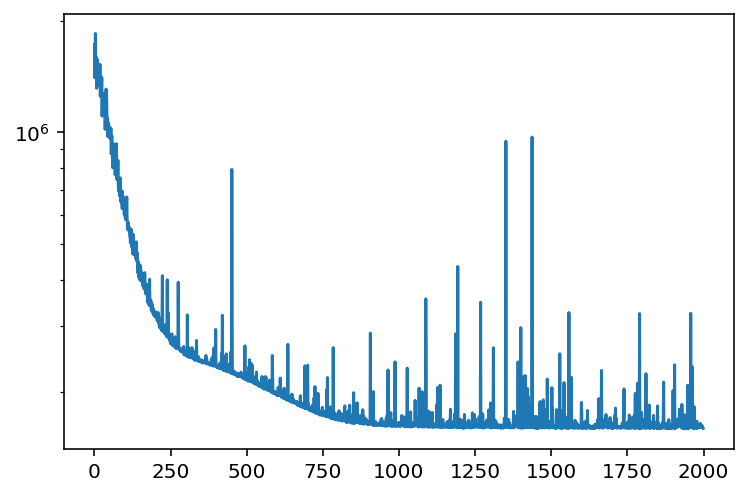

In [87]:
plt.semilogy(svi.loss)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


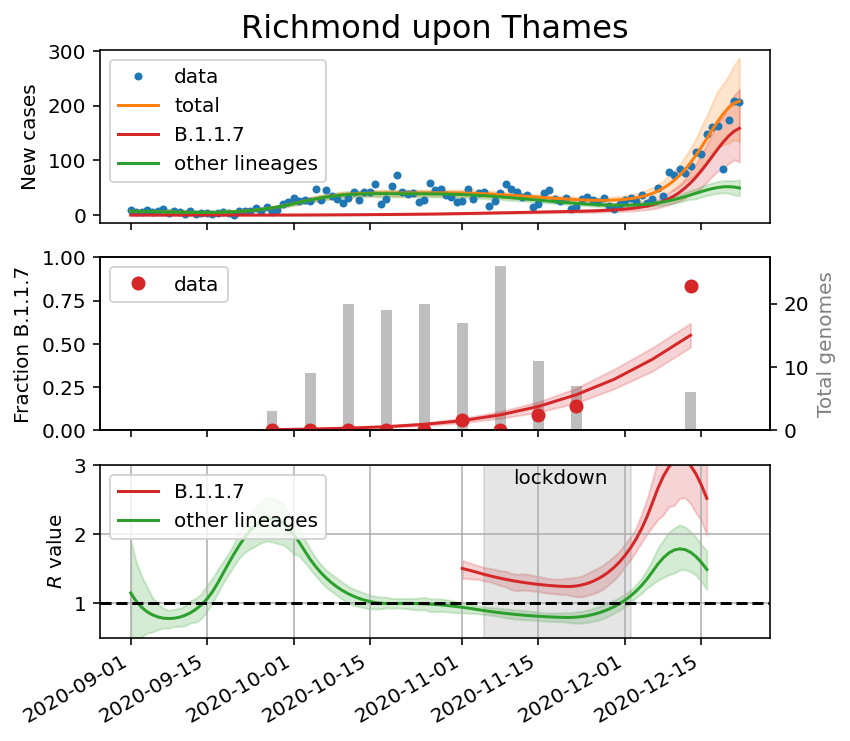

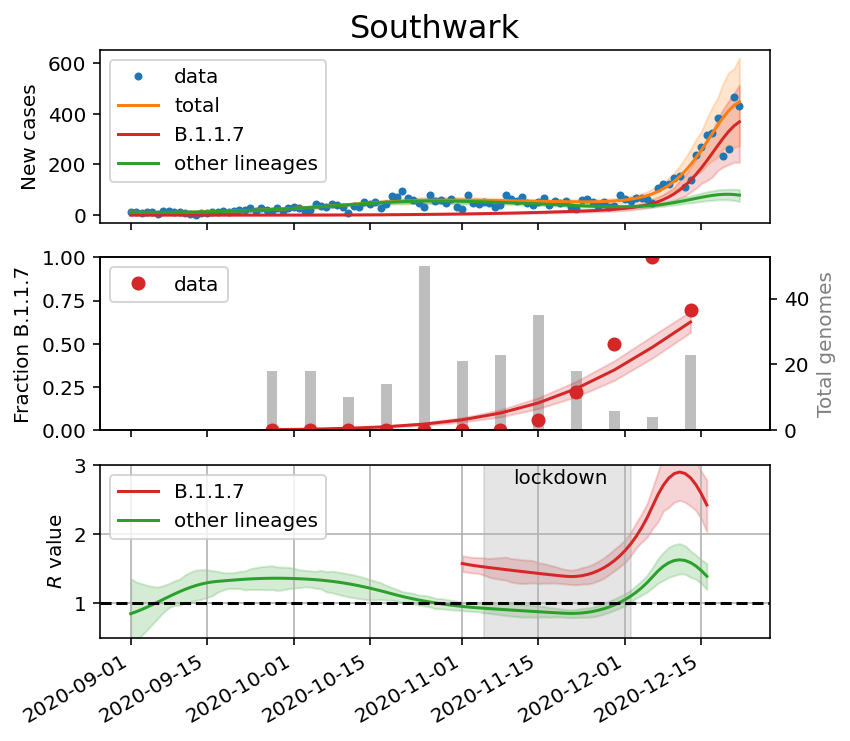

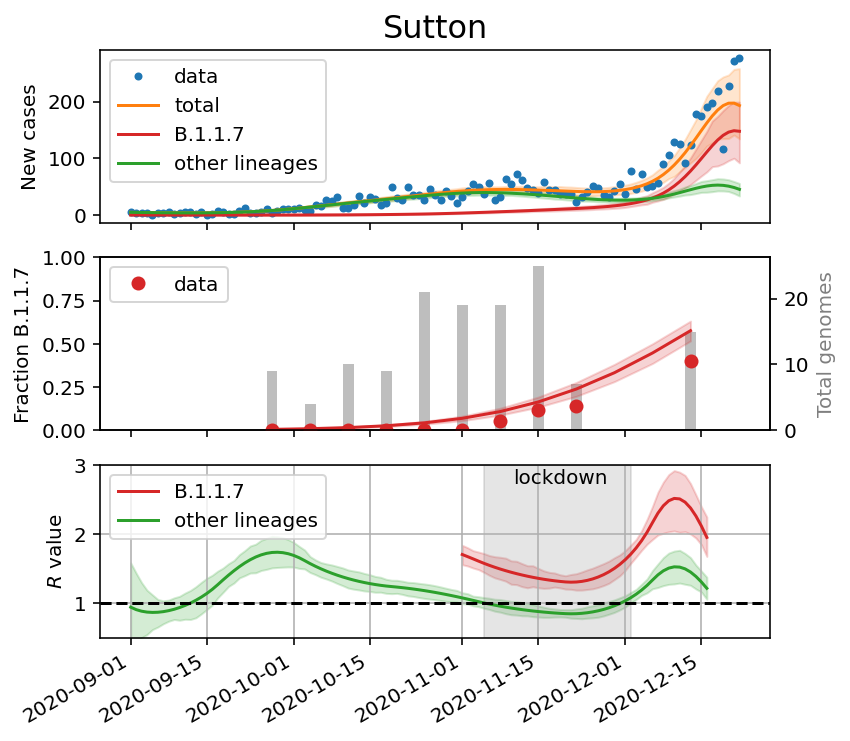

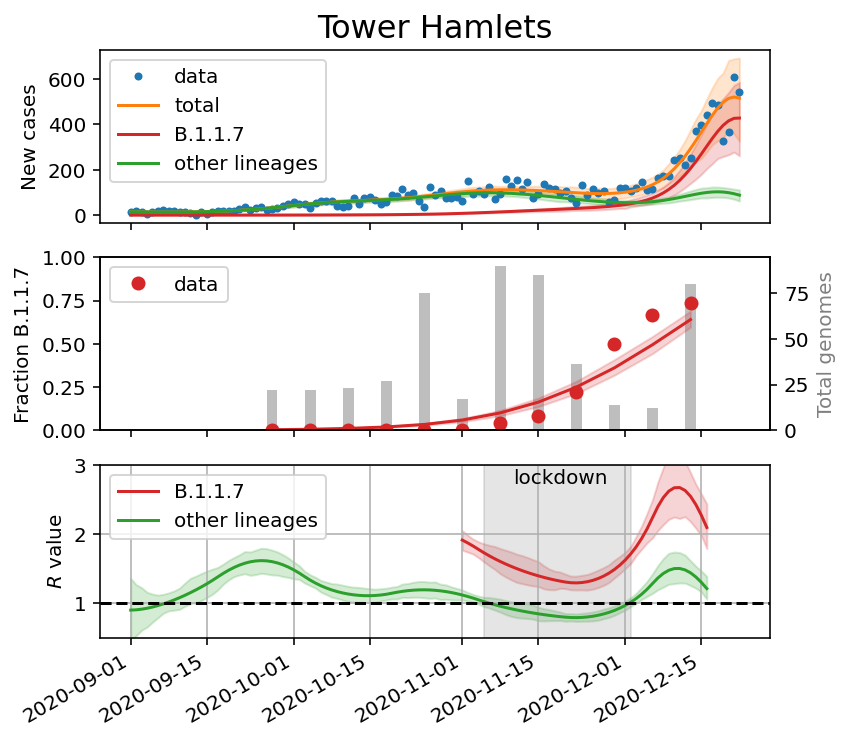

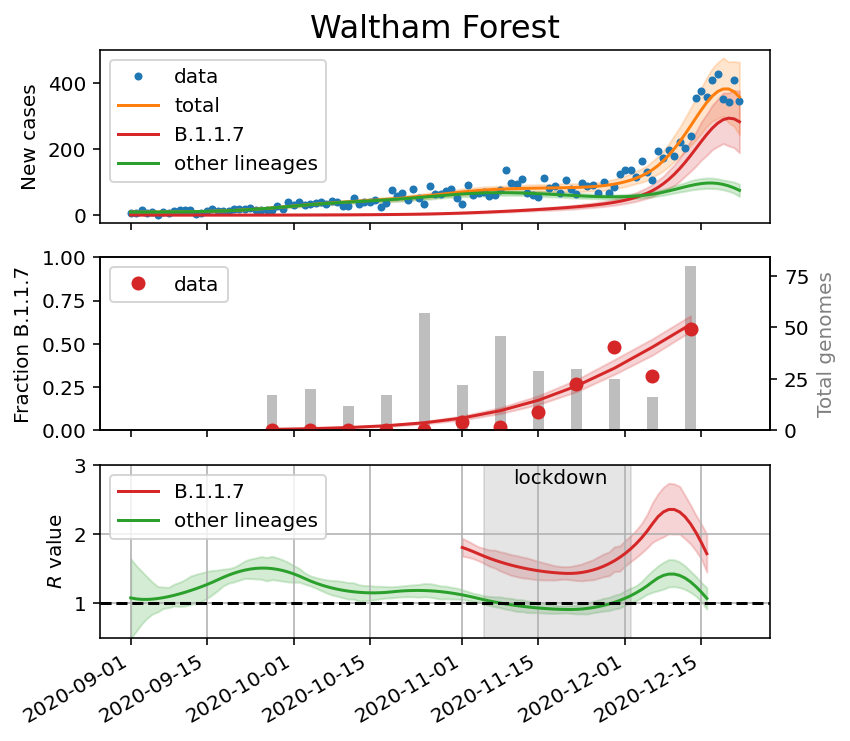

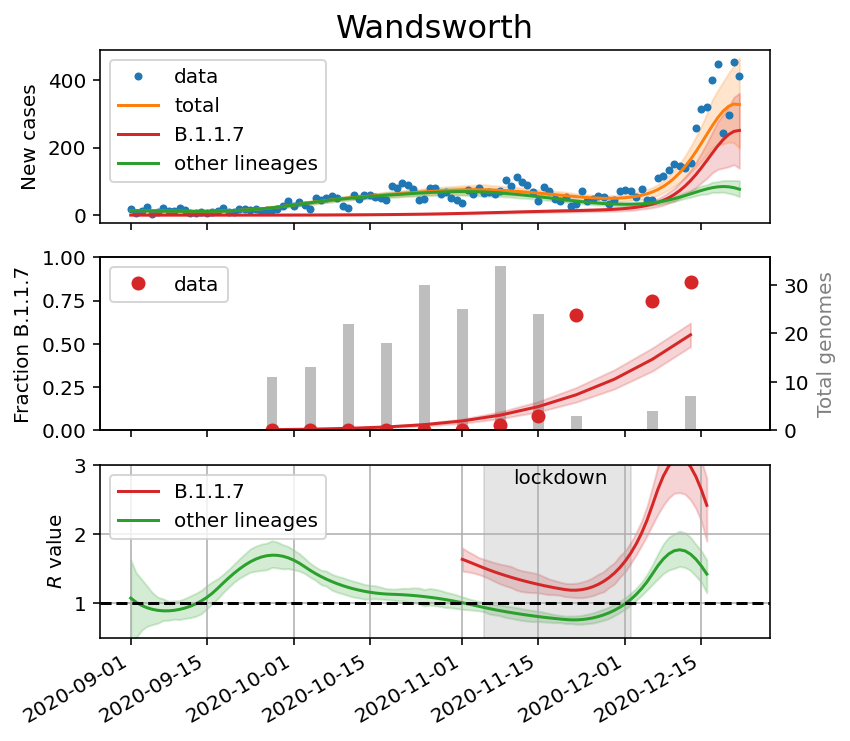

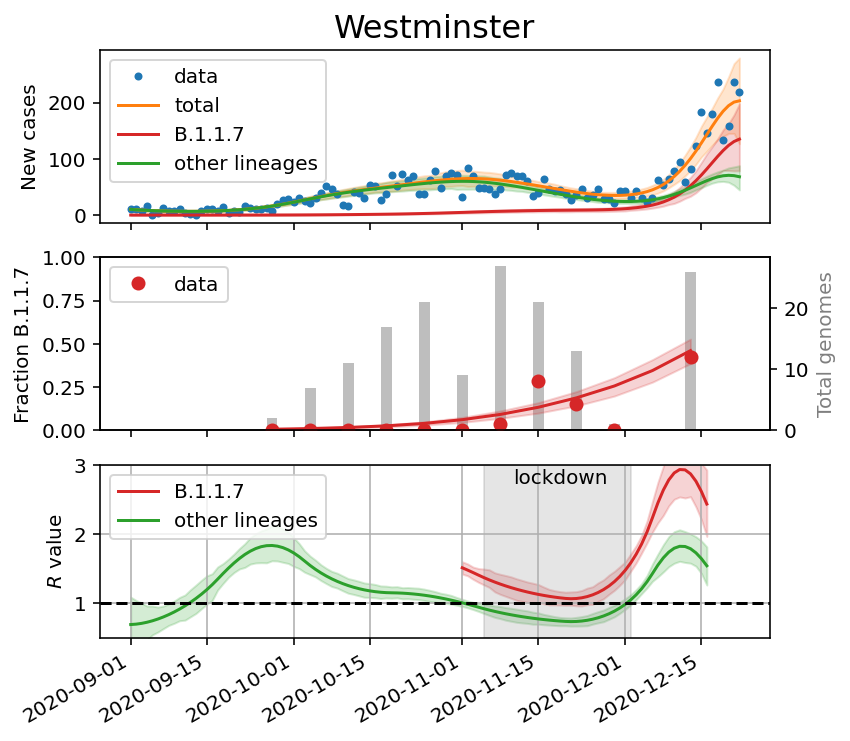

In [88]:
for i in range(310,317):
    try:
        plot(i)
    except:
        pass

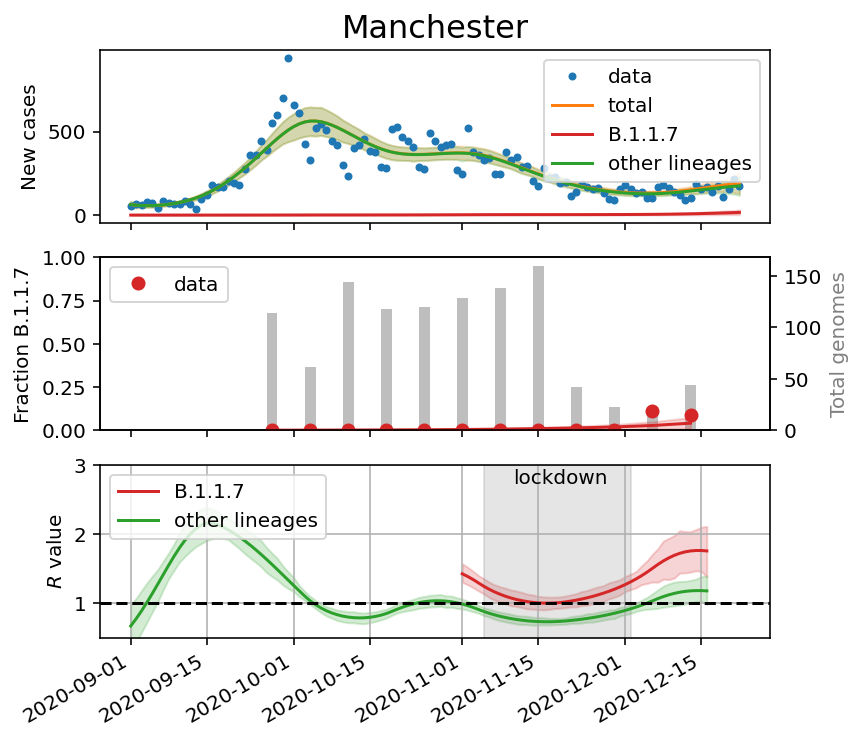

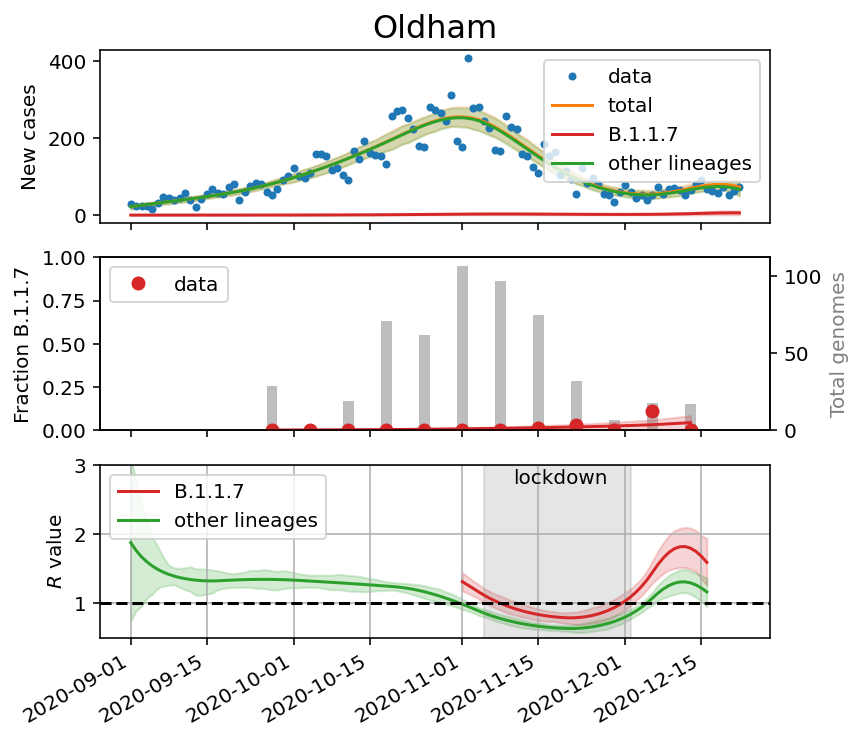

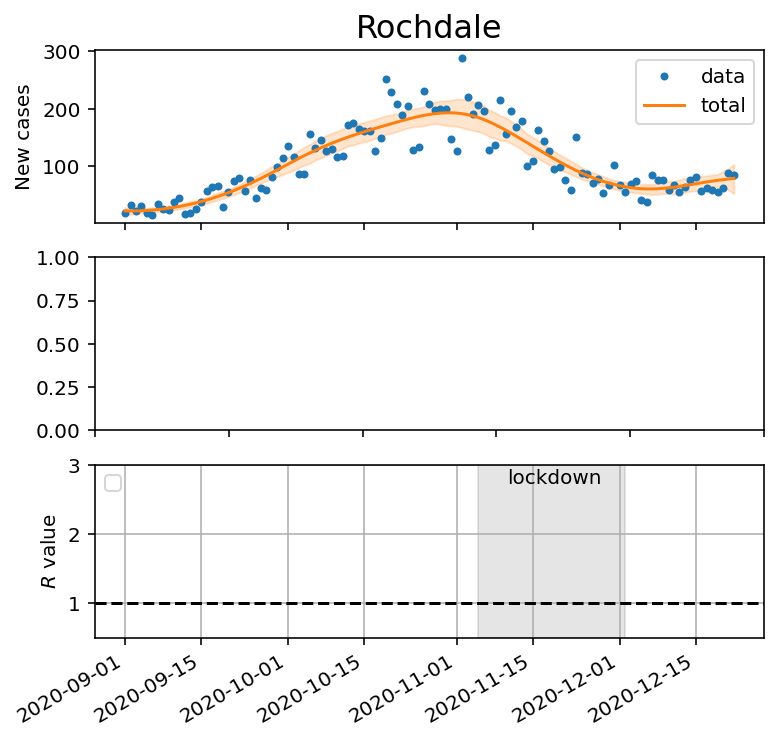

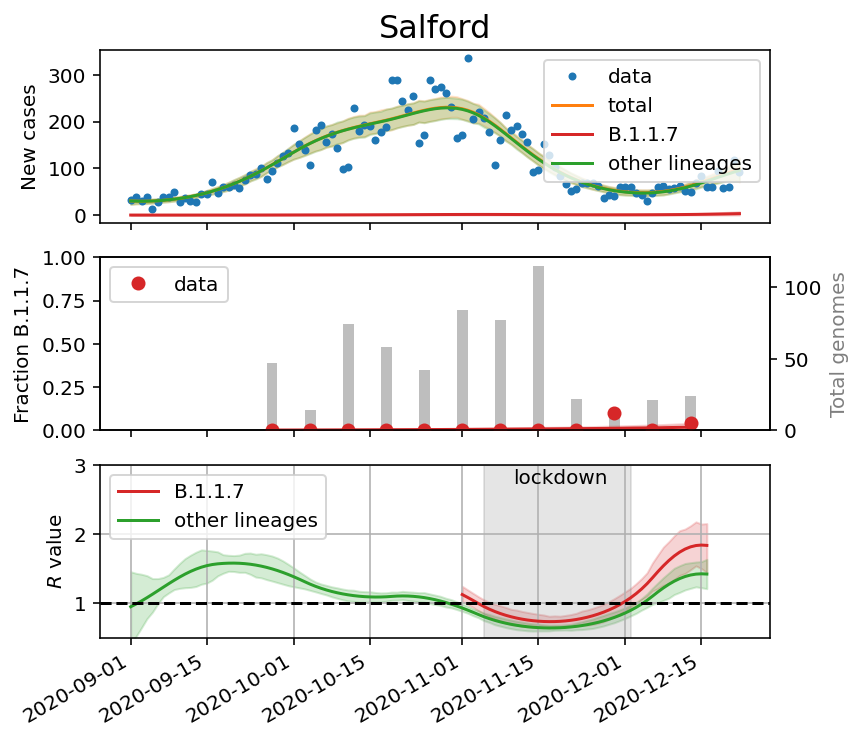

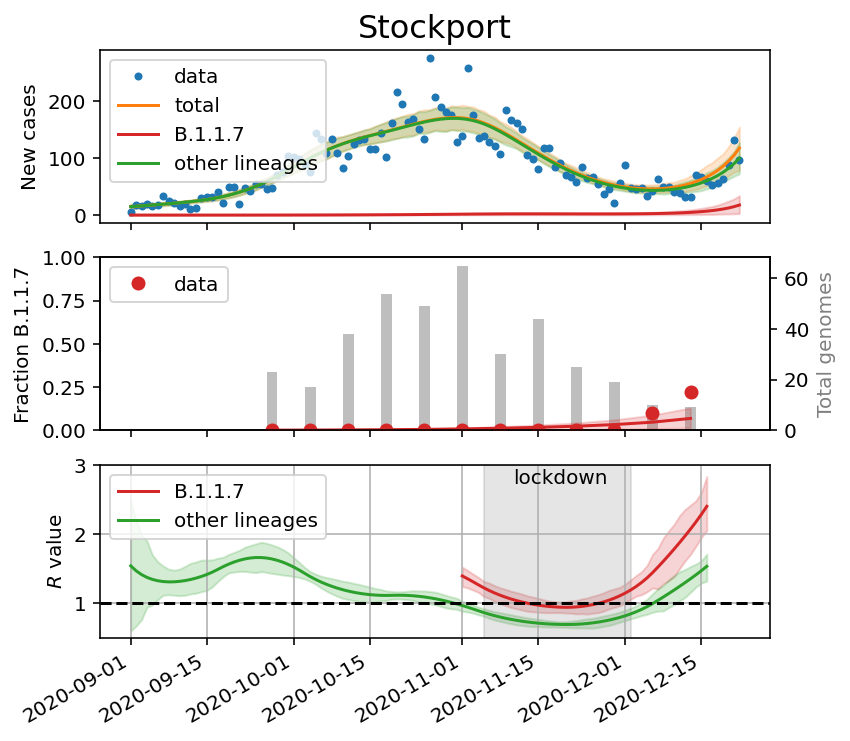

In [89]:
for i in range(250,255):
    try:
        plot(i)
    except:
        pass

In [90]:
np.where(LAD.lad19nm.values == "Thurrock")

(array([31]),)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


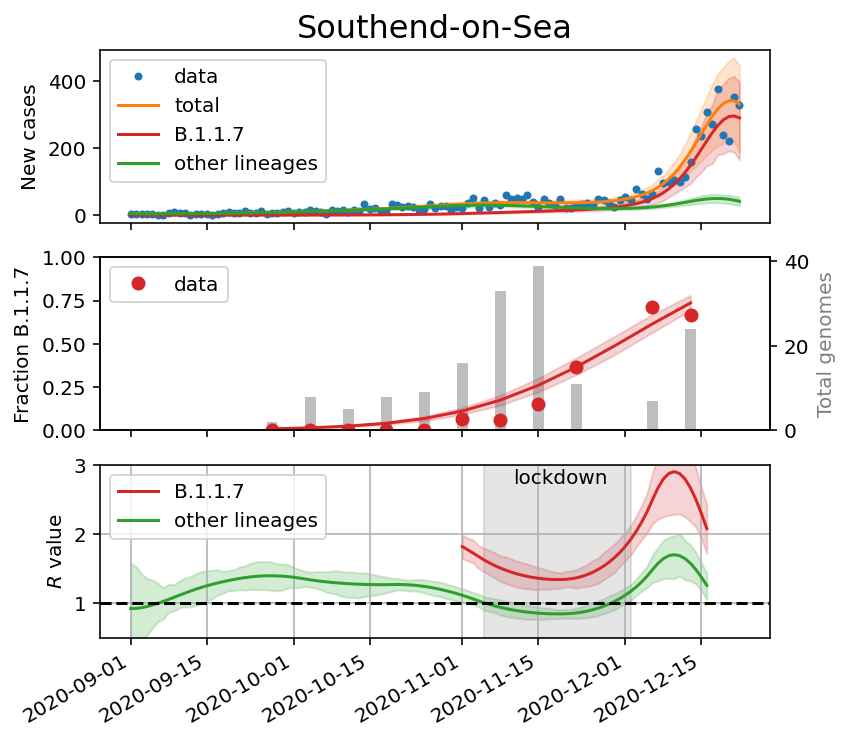

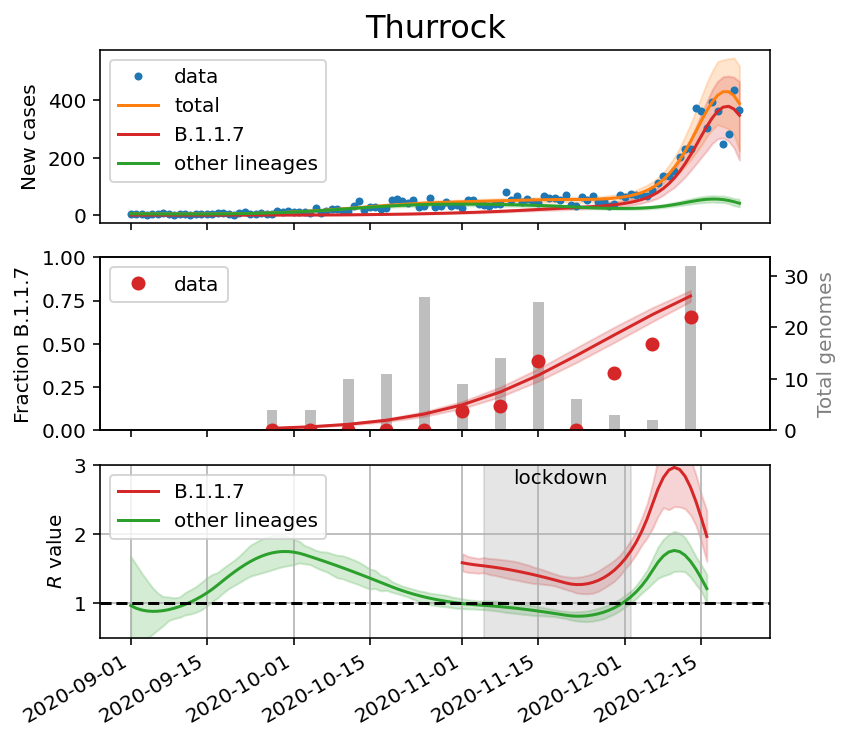

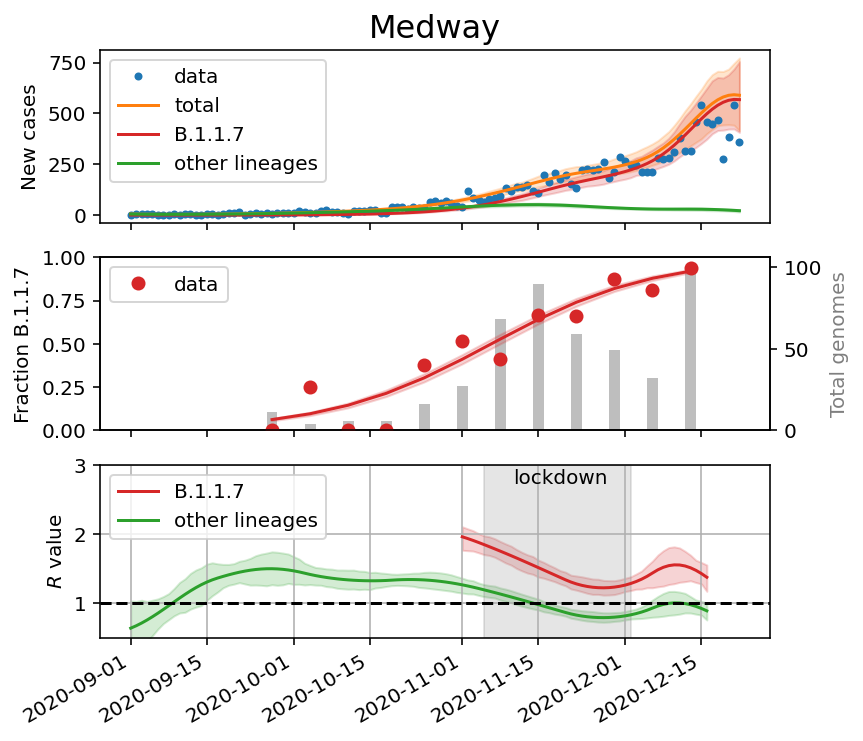

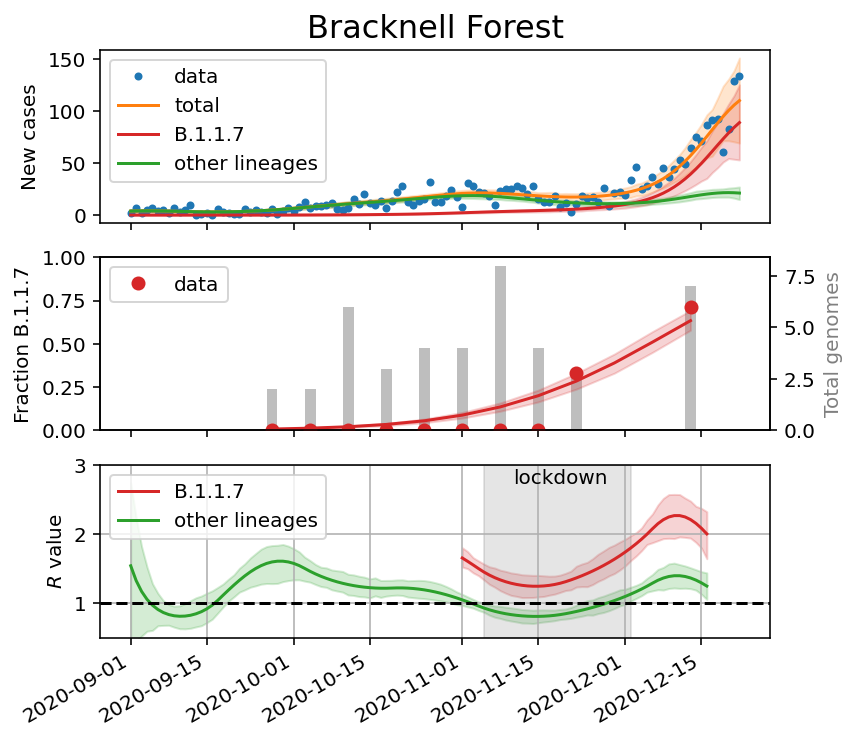

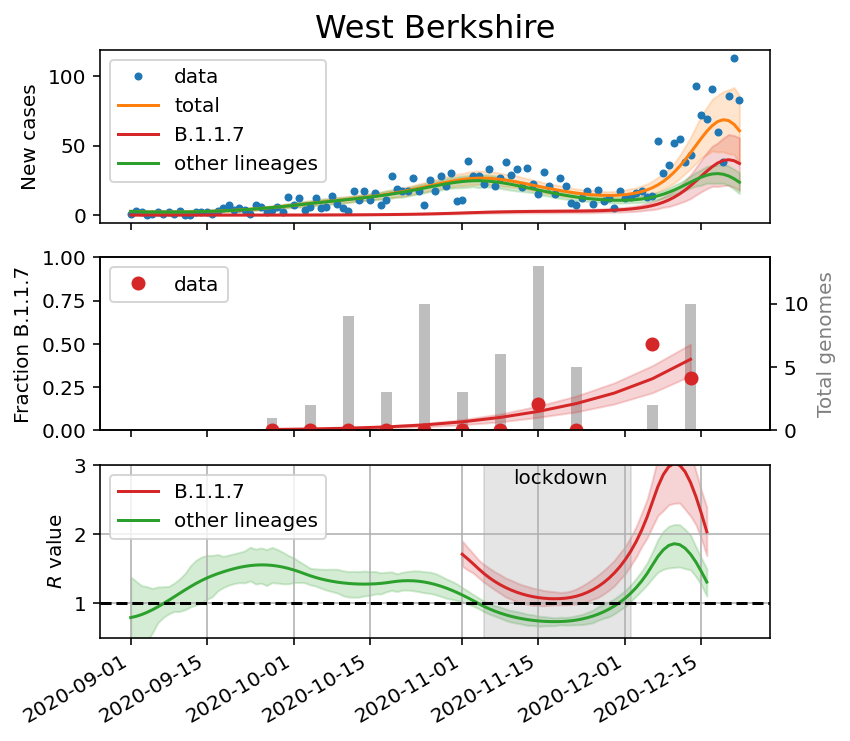

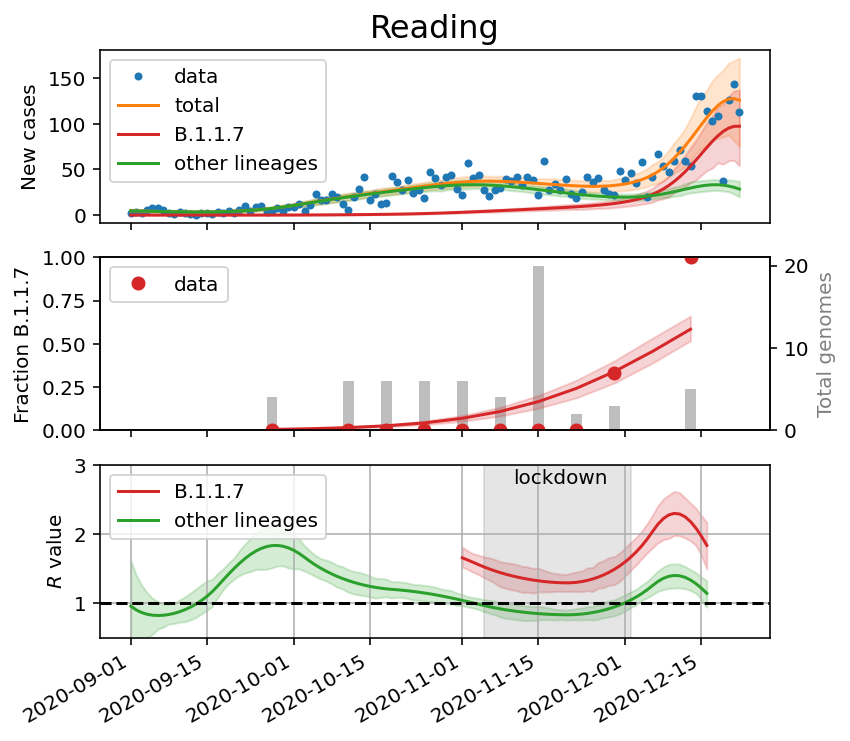

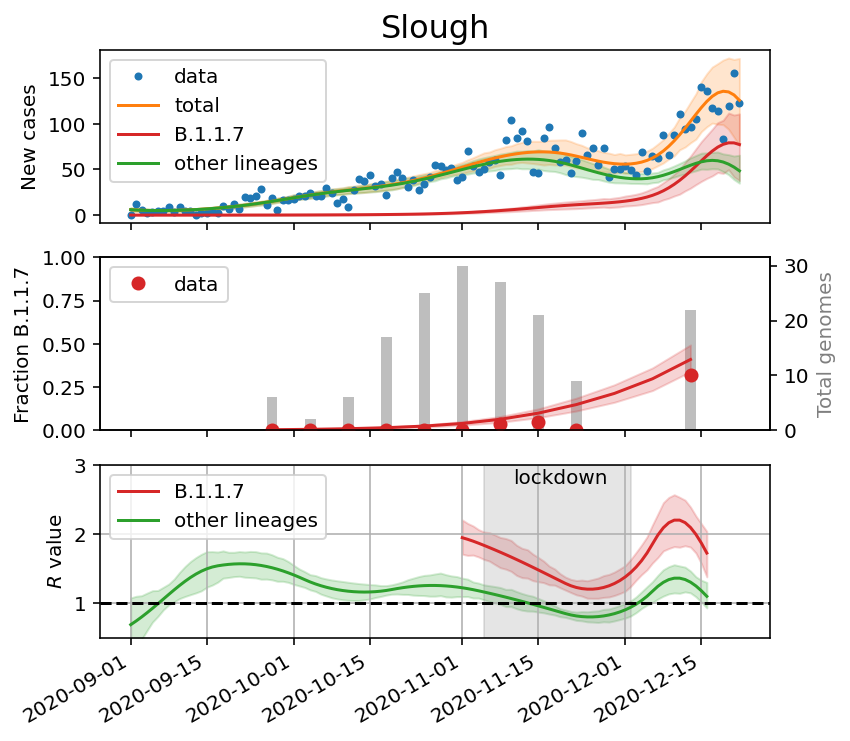

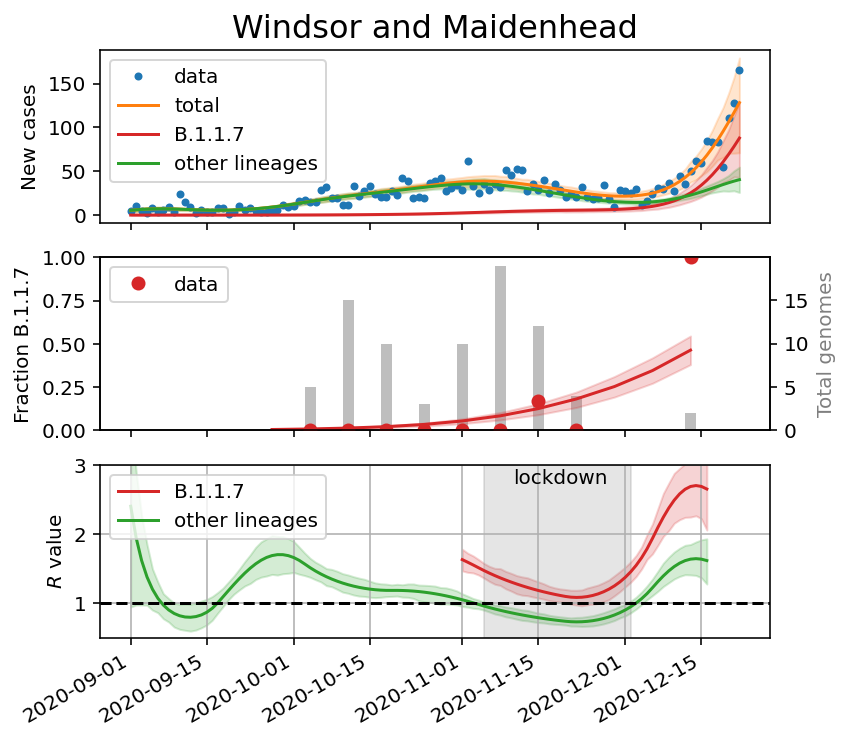

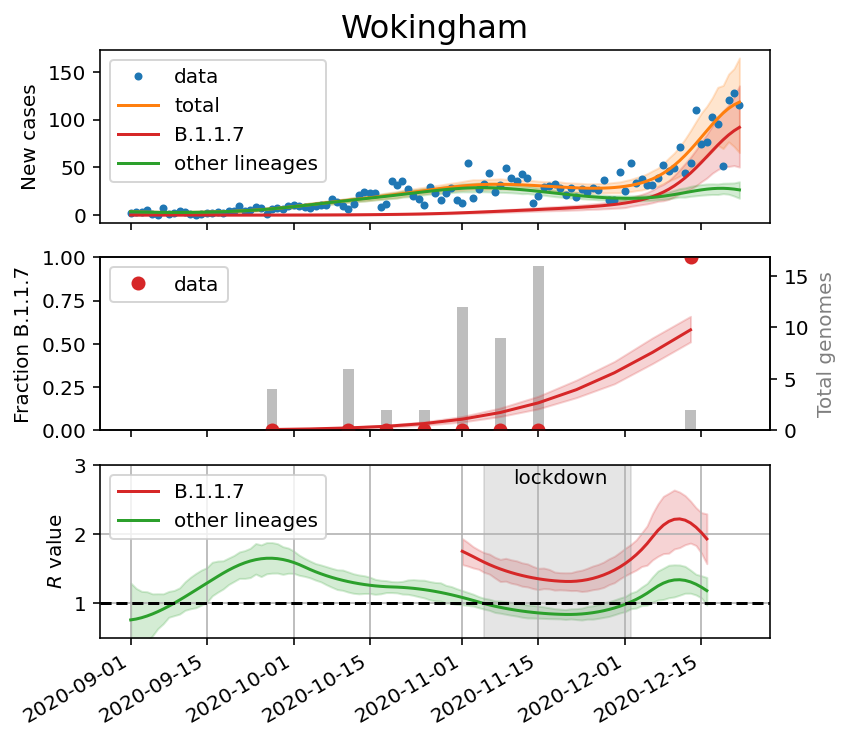

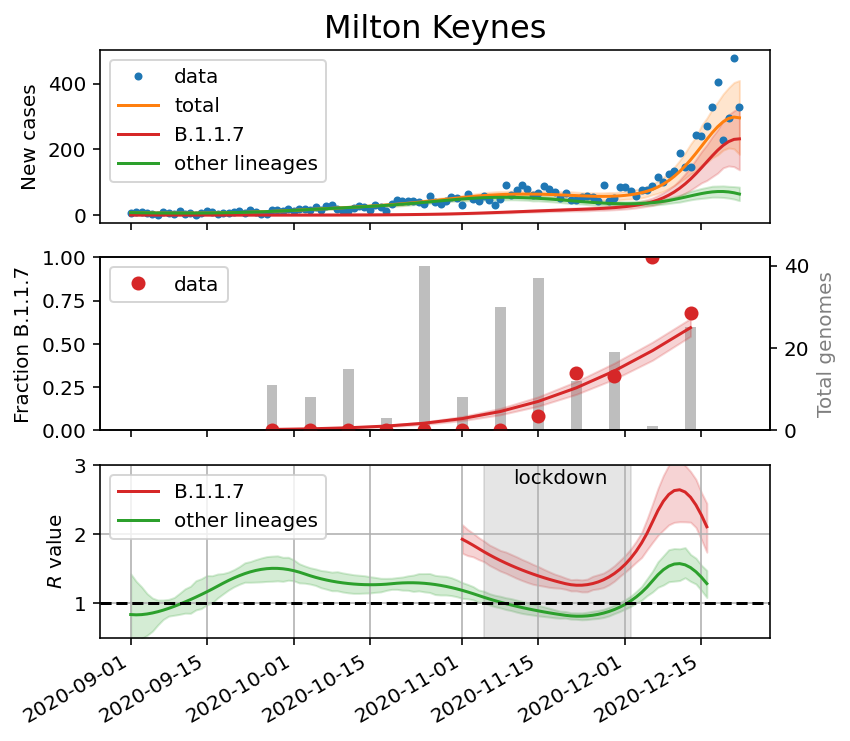

In [91]:
for i in range(30,40):
    try:
        plot(i)
    except:
        pass

In [92]:
np.where(LAD.lad19nm.values == "Cambridge")

(array([60]),)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


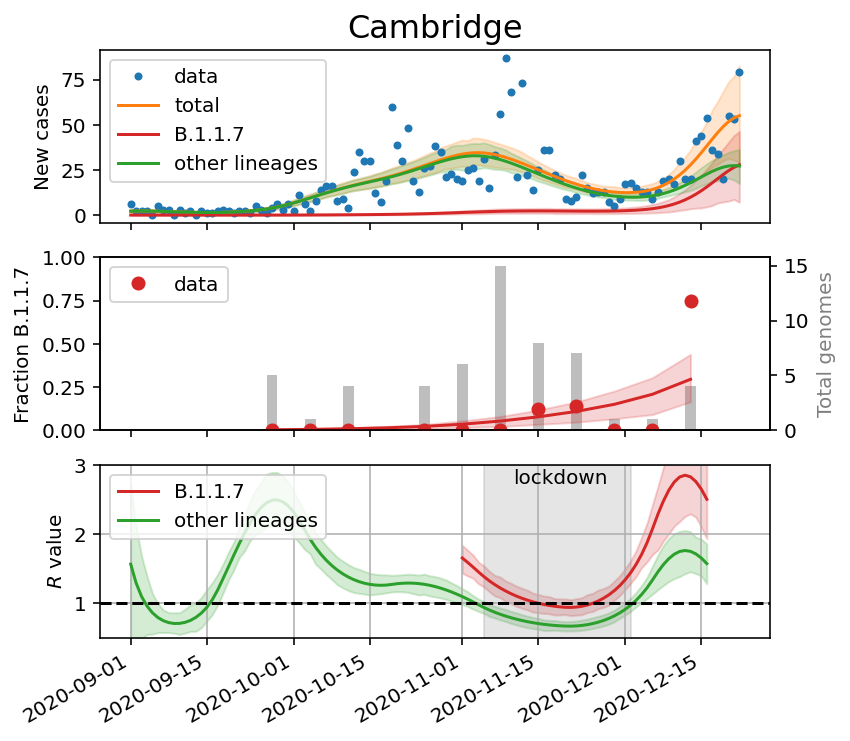

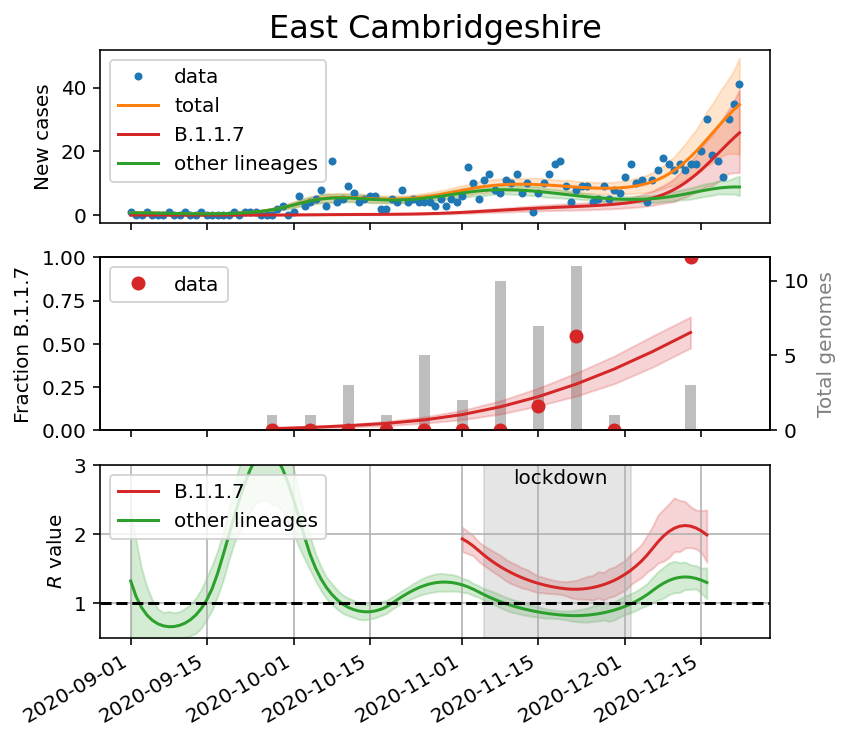

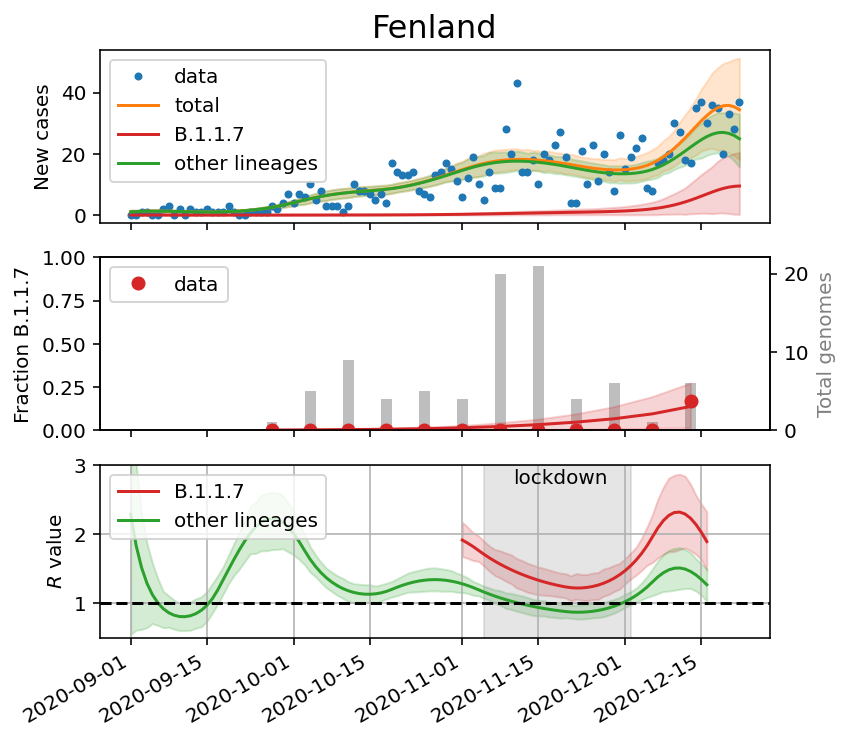

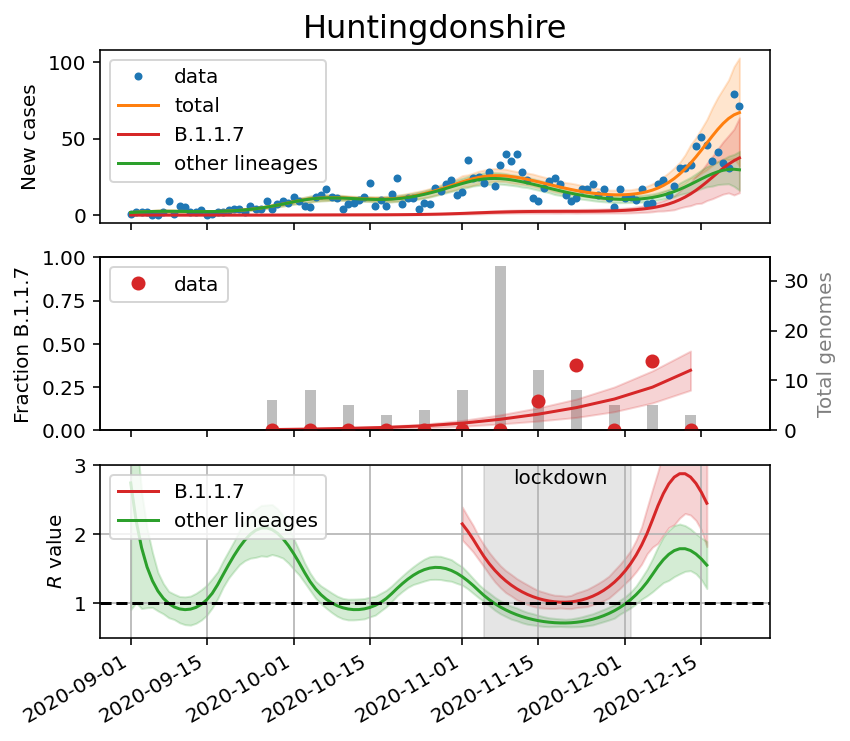

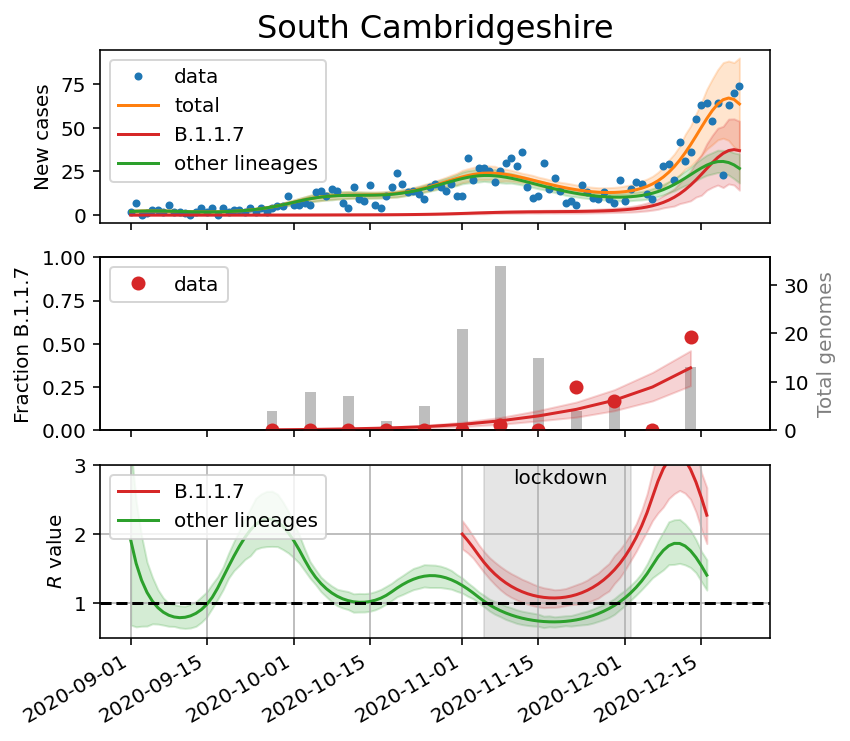

In [93]:
for i in range(60,65):
    try:
        plot(i)
    except:
        pass

In [94]:
R_lockdown0min = np.delete(svi.posterior['R_base'][:,:,65:92].mean(0).min(1), S)
R_lockdownmin = np.array([svi.posterior['R_base'][:,S,65:92].mean(0).min(1), 
            svi.posterior['R_strain'][:,S,65:92].mean(0).min(1)])

In [209]:
(R_lockdownmin > 1).mean(1)

array([0.        , 0.64344262])

<Figure size 432x288 with 0 Axes>

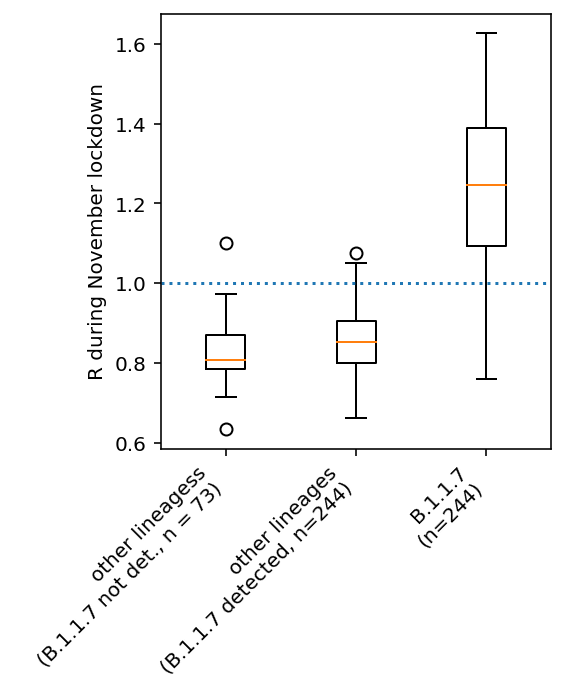

<Figure size 432x288 with 0 Axes>

In [191]:
R_lockdown0 = np.delete(svi.posterior['R_base'][:,:,65:92].mean(2), S, axis=1)
other = LAD['ctry19nm'].drop(S) != "England"
R_lockdown = np.array([svi.posterior['R_base'][:,S,65:92].mean(2), 
            svi.posterior['R_strain'][:,S,65:92].mean(2)])
w = strain[S,:].sum(1)>0
plt.figure(figsize=(3.5,4))
ax = plt.axes()
plt.xlim(-.5,2.5)
plt.boxplot([R_lockdown0.mean(0)[~other], R_lockdown.mean(1)[0,w], R_lockdown.mean(1)[1,w]], positions=range(3)) #, R_lockdown0.mean(0)[other]
plt.xticks(range(3), labels = [f"other lineagess\n (B.1.1.7 not det., n = {(~other).sum()})", f"other lineages\n (B.1.1.7 detected, n={len(S)})", f"B.1.1.7\n(n={len(S)})"], 
           rotation=45, ha="right") #, f"Other nations\n(no genomic data n={other.sum()})",
plt.ylabel("R during November lockdown")
plt.plot(ax.get_xlim(), [1,1], ":")
plt.figure(facecolor="white")
#plt.boxplot()

In [97]:
R_lockdown.shape

(2, 1000, 244)

In [98]:
np.quantile(R_lockdown[0,:], [.25,.5,.75])

array([0.79422766, 0.85344633, 0.91056818])

In [99]:
np.quantile(R_lockdown[1,:], [.25,.5,.75])

array([1.09241652, 1.24513471, 1.39069837])

In [215]:
(R_lockdown[1,:] > 1 ).mean()

0.8754303278688524

In [199]:
(LAD["ctry19nm"]=="England").sum()

317

In [202]:
total[S,:].sum()

44418.0

In [101]:
def pivot_table(X, v):
    return np.array([(X==vv).sum() for vv in v])

In [102]:
w = strain[S,:6].sum(1)>-1
escape =  (R_lockdown > 1 )
e = np.einsum('i,ijk',np.arange(1,3), escape)
p = np.array([pivot_table(X, range(4)) for X in e[...,w]])

In [103]:
q = np.quantile(p,[.025,.5,.975], axis=0)
q

array([[ 25.,   0., 197.,   6.],
       [ 30.,   0., 203.,  10.],
       [ 36.,   0., 210.,  15.]])

In [192]:
np.quantile(p/S.shape[0],[.025,.5,.975], axis=0)


array([[0.10245902, 0.        , 0.80737705, 0.02459016],
       [0.12295082, 0.        , 0.83196721, 0.04098361],
       [0.14754098, 0.        , 0.86065574, 0.06147541]])

Text(0, 0.5, 'Number of LTLAs')

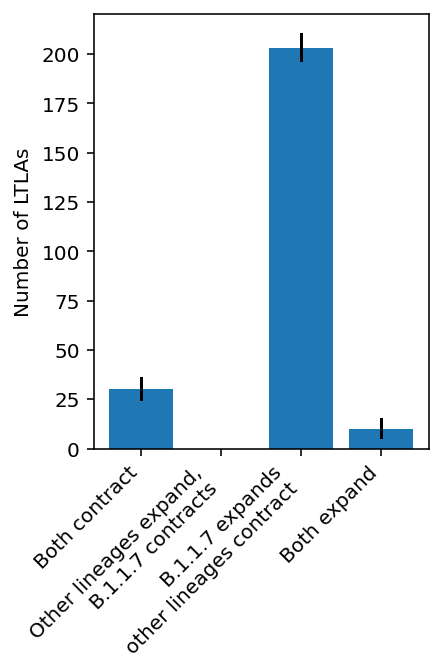

In [104]:
plt.figure(figsize=(3,4))
plt.bar(np.arange(4), q[1,:])
for i in range(4):
    plt.plot([i,i], q[::2,i], c='black')
plt.xticks(range(4), labels = ["Both contract", "Other lineages expand,\n B.1.1.7 contracts", "B.1.1.7 expands\nother lineages contract", "Both expand"], 
           rotation=45, ha="right")
plt.ylabel("Number of LTLAs")

In [105]:
np.quantile(p,[.025,.5,.975], axis=0)/S.shape[0]


array([[0.10245902, 0.        , 0.80737705, 0.02459016],
       [0.12295082, 0.        , 0.83196721, 0.04098361],
       [0.14754098, 0.        , 0.86065574, 0.06147541]])

Text(0.99, 0.01, 'B.1.1.7 contracts\nother expand')

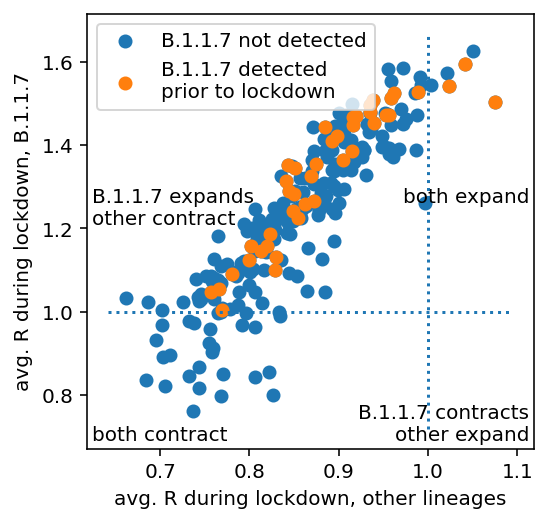

In [106]:
w = np.where(strain[S,:6].sum(1)>0)[0]
plt.figure(facecolor="white", figsize=(4,4))
ax = plt.axes()
plt.scatter(R_lockdown.mean(1)[0,], R_lockdown.mean(1)[1,], label="B.1.1.7 not detected")
plt.scatter(R_lockdown.mean(1)[0,w], R_lockdown.mean(1)[1,w], label="B.1.1.7 detected\nprior to lockdown")
plt.legend()
plt.xlabel("avg. R during lockdown, other lineages")
plt.ylabel("avg. R during lockdown, B.1.1.7")
#plt.plot([.5,1.5], [.5, 1.5],":")
plt.plot(ax.get_xlim(), [1,1],":", c="C0")
plt.plot([1, 1], ax.get_ylim(),":", c="C0")
plt.text(0.01, 0.01, 'both contract', ha='left',va="bottom", transform=ax.transAxes)
plt.text(0.01, .6, 'B.1.1.7 expands\nother contract', ha='left',va="top", transform=ax.transAxes)
plt.text(0.99, 0.6, 'both expand', ha='right',va="top", transform=ax.transAxes)
plt.text(0.99, 0.01, 'B.1.1.7 contracts\nother expand', ha='right',va="bottom", transform=ax.transAxes)
#plt.plot([.5,1.5], np.array([.5, 1.5])**1.05)

In [107]:
w

array([  2,  11,  12,  22,  23,  24,  34,  64,  66,  85,  89,  96,  97,
        98,  99, 100, 101, 102, 104, 105, 106, 107, 129, 150, 151, 153,
       157, 158, 164, 175, 212, 214, 216, 221, 224, 226, 227, 232, 233,
       234, 237, 241])

In [108]:
svi.get_posterior_predictive(B, Bdiff, strain_times, S, C, U, N, specimen, strain[S], total[S], return_sites=('a0','b0','b','a'))

In [109]:
a0 = np.exp(svi.posterior_predictive['a0'].squeeze() * 0.05)
b0 = np.exp(svi.posterior_predictive['b0'].squeeze() * 0.05 * 6.5) 
q0 = np.quantile(np.array([b0, 1/a0]), [0.025,0.5,0.975], axis=1)
q0

array([[1.41431352, 0.88127096],
       [1.46758133, 0.88673973],
       [1.52594128, 0.89212855]])

In [110]:
1/q0

array([[0.70705681, 1.13472479],
       [0.68139324, 1.12772662],
       [0.65533321, 1.12091469]])

([<matplotlib.axis.XTick at 0x7fd192b63d90>,
 [Text(0, 0, 'R (other lineages R=1)'), Text(1, 0, 'Serial interval')])

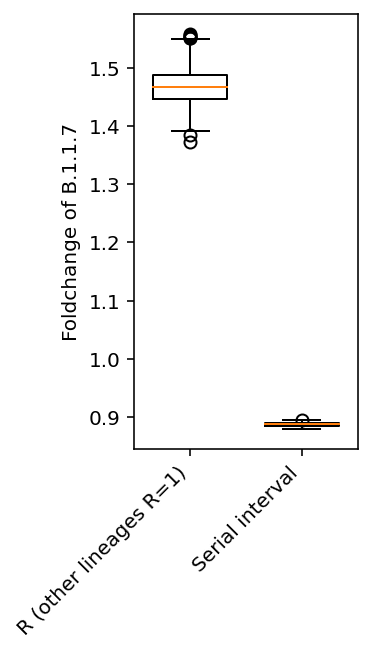

In [111]:
plt.figure(figsize=(2,4))
plt.boxplot([b0.squeeze(), 1/a0.squeeze()], widths=.66, positions=range(2))
#plt.bar(np.arange(2), q0[1,:]-1, bottom=1)
#for i in range(2):
#    plt.plot([i,i], q0[::2,i], c='black')
plt.ylabel("Foldchange of B.1.1.7")
plt.xticks(range(2), labels = ["R (other lineages R=1)", "Serial interval"], 
           rotation=45, ha="right")


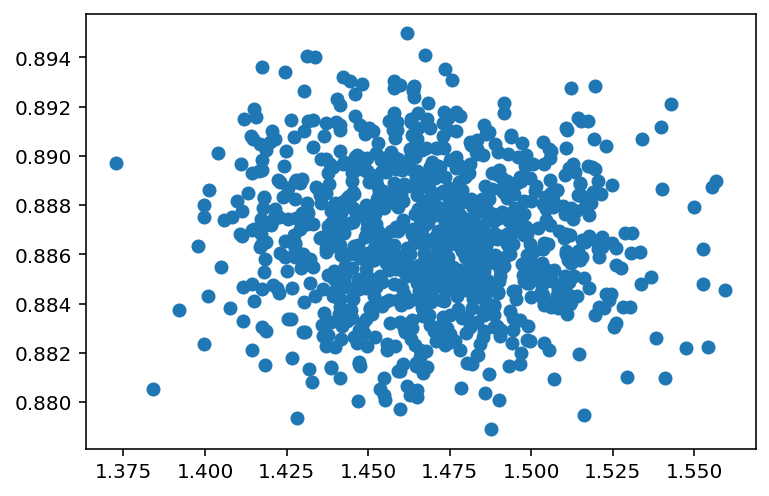

In [112]:
plt.scatter(b0 , 1/a0)

In [207]:
a = np.exp(svi.posterior_predictive['a'].squeeze().mean(0) * 0.05)
b = np.exp(svi.posterior_predictive['b'].squeeze().mean(0) * 0.05 * 6.5) 
q = np.quantile(np.array([b, 1/a]), [0.25,0.5,0.75], axis=1)
q

array([[1.43445727, 0.86425292],
       [1.48830068, 0.87827533],
       [1.54522866, 0.89871539]])

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


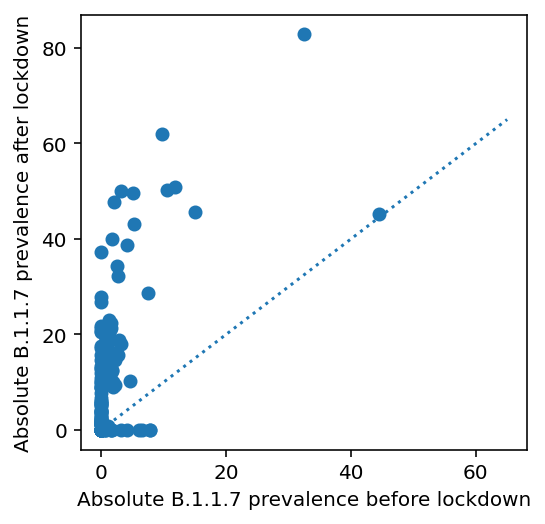

In [113]:
plt.figure(figsize=(4,4))
plt.scatter(specimen[S,65] * strain[S,6]/total[S,6] / N[S] * 1e5, specimen[S,95] * strain[S,10]/total[S,10]/ N[S] * 1e5)
plt.xlabel("Absolute B.1.1.7 prevalence before lockdown")
plt.ylabel("Absolute B.1.1.7 prevalence after lockdown")
plt.plot([0,65],[0,65], ":")

In [114]:
s = strain + .5
t = total + 1
x = specimen[S,92] * (1- s[S,10]/t[S,10]) / (specimen[S,58] * (1-s[S,5:6].sum(1)/t[S,5:6].sum(1)) )
y = (specimen[S,92] * s[S,10]/t[S,10]) / (specimen[S,58] * s[S,5:6].sum(1)/t[S,5:6].sum(1) )

In [115]:
from scipy.stats import spearmanr
spearmanr(x, y)

SpearmanrResult(correlation=0.31780709888346037, pvalue=3.9595707707568127e-07)

In [116]:
total[~np.isnan(total)].sum()

44445.0

In [117]:
v = np.logical_or(np.isnan(x + y) , np.isinf(x + y + 1/y + 1/x))

In [118]:
np.corrcoef(x[~v],y[~v])

array([[1.        , 0.10406791],
       [0.10406791, 1.        ]])

Text(0.99, 0.01, 'B.1.1.7 contracts\nother expand')

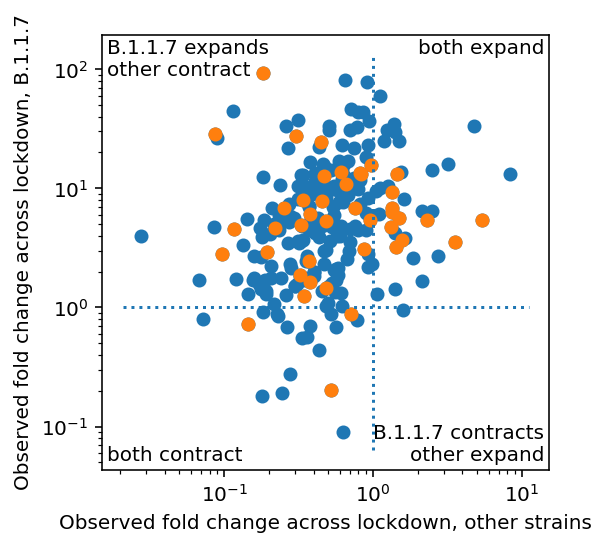

In [119]:
plt.figure(figsize=(4,4))
ax = plt.axes()
w = np.where(strain[S,:6].sum(1)>0)[0]
plt.loglog(x,y, "o")
plt.loglog(x[w],y[w], "o")
plt.xlabel("Observed fold change across lockdown, other strains")
plt.ylabel("Observed fold change across lockdown, B.1.1.7")
#plt.plot([3e-1, 4], [3e-1,4],":", c="C0")
plt.plot(ax.get_xlim(), [1,1],":", c="C0")
plt.plot([1, 1], ax.get_ylim(),":", c="C0")
plt.text(0.01, 0.01, 'both contract', ha='left',va="bottom", transform=ax.transAxes)
plt.text(0.01, .99, 'B.1.1.7 expands\nother contract', ha='left',va="top", transform=ax.transAxes)
plt.text(0.99, 0.99, 'both expand', ha='right',va="top", transform=ax.transAxes)
plt.text(0.99, 0.01, 'B.1.1.7 contracts\nother expand', ha='right',va="bottom", transform=ax.transAxes)

In [120]:
LAD

objectid   pop18    lad19cd               lad19nm  lad19id   utla19cd  \
0           1   93242  E06000001            Hartlepool        0  E06000001   
1           2  140545  E06000002         Middlesbrough        1  E06000002   
2           3  136718  E06000003  Redcar and Cleveland        2  E06000003   
3           4  197213  E06000004      Stockton-on-Tees        3  E06000004   
4           5  106566  E06000005            Darlington        4  E06000005   
..        ...     ...        ...                   ...      ...        ...   
377       378   93049  W06000020               Torfaen      377  W06000020   
378       379   94142  W06000021         Monmouthshire      378  W06000021   
379       380  153302  W06000022               Newport      379  W06000022   
380       381  132447  W06000023                 Powys      380  W06000023   
381       382   60183  W06000024        Merthyr Tydfil      381  W06000024   

                 utla19nm  utla19id   ctry19cd ctry19nm  ctry19id  
0              Hartlepool         0  E92000001  England         0  
1           Middlesbrough         0  E92000001  England         0  
2    Redcar and Cleveland         0  E92000001  England         0  
3        Stockton-on-Tees         0  E92000001  England         0  
4              Darlington         0  E92000001  England         0  
..                    ...       ...        ...      ...       ...  
377               Torfaen         3  W92000004    Wales         3  
378         Monmouthshire         3  W92000004    Wales         3  
379               Newport         3  W92000004    Wales         3  
380                 Powys         3  W92000004    Wales         3  
381        Merthyr Tydfil         3  W92000004    Wales         3  

[382 rows x 11 columns]

In [121]:
g = gpd.read_file("https://opendata.arcgis.com/datasets/3a4fa2ce68f642e399b4de07643eeed3_0.geojson")

In [122]:
mu_1 = np.array(svi.posterior['μ_strain'].mean(0)) #+ 1e-16
mu_0 = np.array(svi.posterior['μ_base'].mean(0)) #+ 1e-16

In [167]:
r_0 = mu_0[:,92]/mu_0[:,65]
r_1 = mu_1[:,92]/mu_1[:,65]
r_t = ( mu_0[:,92]+ mu_1[:,92])/(mu_0[:,65] + mu_1[:,65])

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


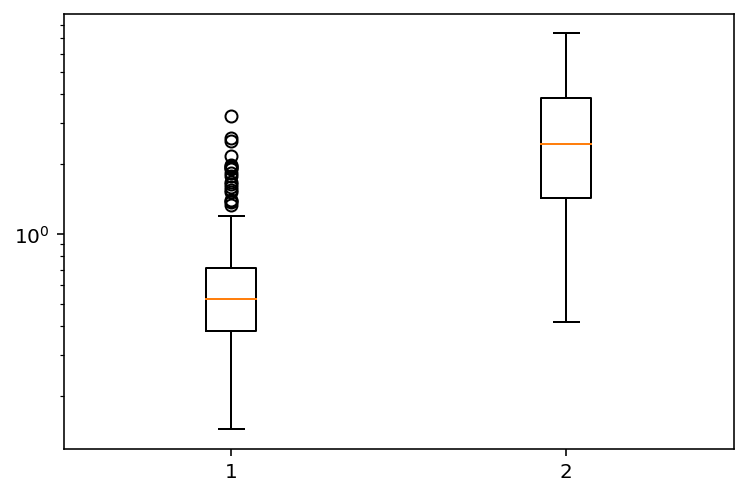

In [124]:
plt.boxplot([r_0,r_1[~np.isnan(r_1)]])
plt.yscale("log")

In [170]:
r_0[LAD['ctry19nm']!="England"] = np.nan

In [126]:
np.isnan(r_1).sum()

138

In [171]:
g['ctry19nm']=LAD['ctry19nm']
nations =g.dissolve(by='ctry19nm')

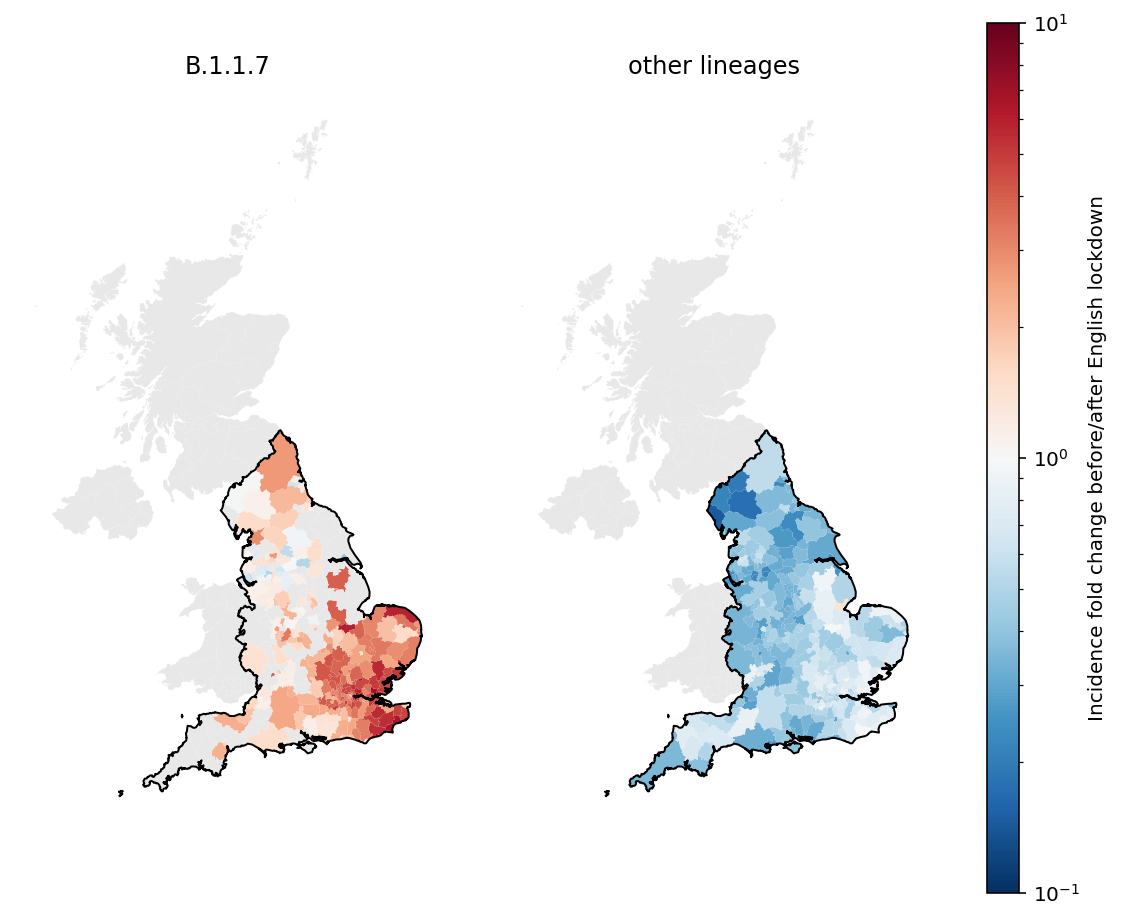

In [181]:
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
g['r_0']= r_0
g['r_1'] = r_1
g['r_t'] = r_t
fig, ax = plt.subplots(1, 3, figsize=(9, 8),  gridspec_kw={'width_ratios': [10, 10, .75]}, facecolor="white")
g.plot(column='r_0', ax=ax[1], cmap="RdBu_r", norm=colors.LogNorm(vmin=0.1, vmax=10), 
       legend_kwds={'label': "Incidence fold change before/after English lockdown"},
      missing_kwds={ "color": "#E8E8E8", "label": "Missing values"})
nations.loc[["England"],:].plot(color="none", edgecolor="black", ax=ax[1])
ax[1].set_title("other lineages")
ax[1].set_axis_off()
g.plot(column='r_1', ax=ax[0], cmap="RdBu_r", norm=colors.LogNorm(vmin=0.1, vmax=10), legend=True, cax=ax[2], 
       legend_kwds={'label': "Incidence fold change before/after English lockdown"},
      missing_kwds={ "color": "#E8E8E8", "label": "Missing values"})
nations.loc[["England"],:].plot(color="none", edgecolor="black", ax=ax[0])
ax[0].set_title("B.1.1.7")
ax[0].set_axis_off()

Text(0, 0.5, 'Number of LTLAs')

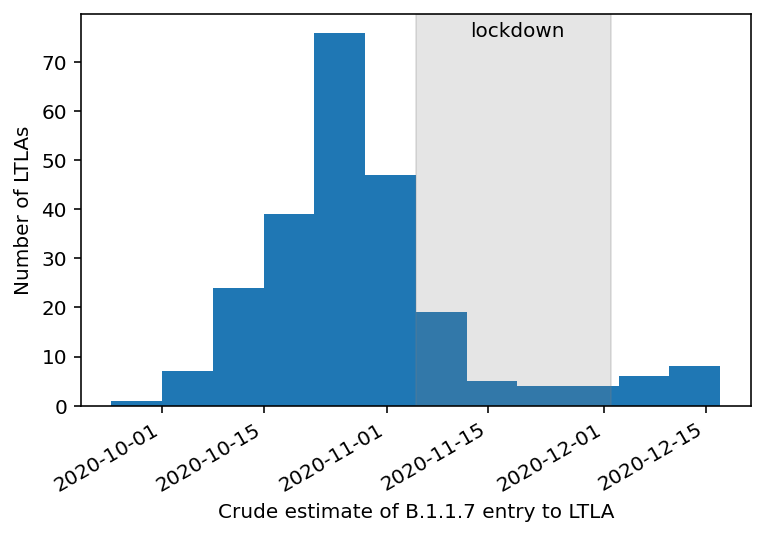

In [128]:
t1 = (mu_1 * N.reshape(-1,1) > 1).argmax(1)
v = t1 != 0
d = pd.date_range(start='2020-09-01', periods=specimen.shape[1], freq='d').to_pydatetime()
ax = plt.axes()
h = plt.hist(d[t1[v]], bins = d[23::7])
#plt.hist(d[strain_times-3][np.argmax(strain>0, axis=1)[v]], bins=h[1], alpha=0.5)
plt.gcf().autofmt_xdate()
plt.axvspan(d[65], d[92], color='C7', alpha=.2)
#plt.grid(True)
plt.text(d[79], ax.get_ylim()[1]*.98, "lockdown", ha = 'center', va='top')
plt.xlabel("Crude estimate of B.1.1.7 entry to LTLA")
plt.ylabel("Number of LTLAs")

Text(0.5, 0, 'time between onset and discovery')

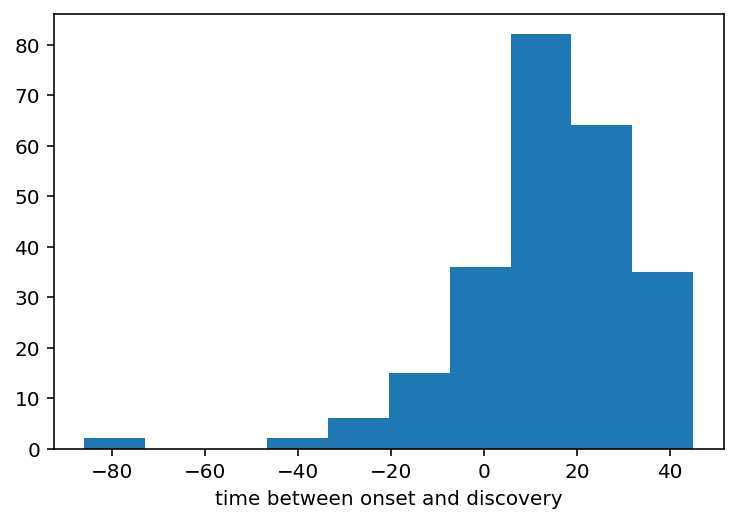

In [129]:
plt.hist([x. days for x in d[strain_times-3][np.argmax(strain>0, axis=1)[v]] - d[t1[v]]])
plt.xlabel("time between onset and discovery")

In [130]:
wk = np.array([(np.arange(113) / 7).astype("int")  == i for i in range(16)]).T
wks = specimen @ wk

Text(0, 0.5, 'genomes')

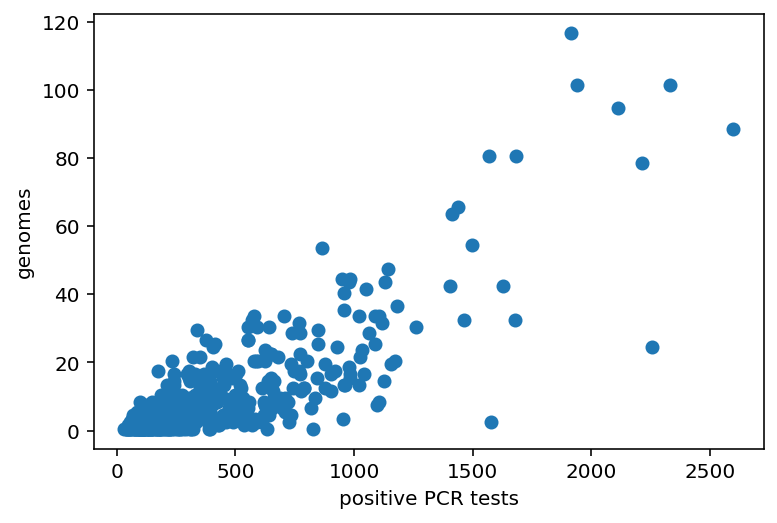

In [131]:
plt.plot(wks[:,13:15].flatten()+.5, total[:,10:].flatten()+.5, "o")
plt.xlabel("positive PCR tests")
plt.ylabel("genomes")


In [68]:
LAD

objectid   pop18    lad19cd               lad19nm  lad19id   utla19cd  \
0           1   93242  E06000001            Hartlepool        0  E06000001   
1           2  140545  E06000002         Middlesbrough        1  E06000002   
2           3  136718  E06000003  Redcar and Cleveland        2  E06000003   
3           4  197213  E06000004      Stockton-on-Tees        3  E06000004   
4           5  106566  E06000005            Darlington        4  E06000005   
..        ...     ...        ...                   ...      ...        ...   
377       378   93049  W06000020               Torfaen      377  W06000020   
378       379   94142  W06000021         Monmouthshire      378  W06000021   
379       380  153302  W06000022               Newport      379  W06000022   
380       381  132447  W06000023                 Powys      380  W06000023   
381       382   60183  W06000024        Merthyr Tydfil      381  W06000024   

                 utla19nm  utla19id   ctry19cd ctry19nm  ctry19id  
0              Hartlepool         0  E92000001  England         0  
1           Middlesbrough         0  E92000001  England         0  
2    Redcar and Cleveland         0  E92000001  England         0  
3        Stockton-on-Tees         0  E92000001  England         0  
4              Darlington         0  E92000001  England         0  
..                    ...       ...        ...      ...       ...  
377               Torfaen         3  W92000004    Wales         3  
378         Monmouthshire         3  W92000004    Wales         3  
379               Newport         3  W92000004    Wales         3  
380                 Powys         3  W92000004    Wales         3  
381        Merthyr Tydfil         3  W92000004    Wales         3  

[382 rows x 11 columns]

In [75]:
LAD.iloc[S,:].sha

objectid   pop18    lad19cd           lad19nm  lad19id   utla19cd  \
0           1   93242  E06000001        Hartlepool        0  E06000001   
1           2  140545  E06000002     Middlesbrough        1  E06000002   
3           4  197213  E06000004  Stockton-on-Tees        3  E06000004   
5           6  128432  E06000006            Halton        5  E06000006   
6           7  209547  E06000007        Warrington        6  E06000007   
..        ...     ...        ...               ...      ...        ...   
314       315  276700  E09000031    Waltham Forest      314  E09000031   
315       316  326474  E09000032        Wandsworth      315  E09000032   
316       317  255324  E09000033       Westminster      316  E09000033   
365       366  136126  W06000006           Wrexham      365  W06000006   
371       372  144876  W06000013          Bridgend      371  W06000013   

             utla19nm  utla19id   ctry19cd ctry19nm  ctry19id  
0          Hartlepool         0  E92000001  England         0  
1       Middlesbrough         0  E92000001  England         0  
3    Stockton-on-Tees         0  E92000001  England         0  
5              Halton         0  E92000001  England         0  
6          Warrington         0  E92000001  England         0  
..                ...       ...        ...      ...       ...  
314    Waltham Forest         0  E92000001  England         0  
315        Wandsworth         0  E92000001  England         0  
316       Westminster         0  E92000001  England         0  
365           Wrexham         3  W92000004    Wales         3  
371          Bridgend         3  W92000004    Wales         3  

[246 rows x 11 columns]

In [74]:
(LAD.loc[S,"ctry19id"] == 3).sum()

2

# Data update

In [56]:
LAD = c19.get_geodata()
data_request = {
        "date": "date",
        "areaName": "areaName",
        "areaCode": "areaCode",
        "newPillarOneTestsByPublishDate": "newPillarOneTestsByPublishDate",
        "newCasesBySpecimenDate": "newCasesBySpecimenDate",
        "newPillarTwoTestsByPublishDate": "newPillarTwoTestsByPublishDate",
        "newPillarThreeTestsByPublishDate": "newPillarThreeTestsByPublishDate",
        "newPillarFourTestsByPublishDate": "newPillarFourTestsByPublishDate",
        "hospitalCases": "hospitalCases",
        "newDeathsByDeathDate": "newDeathsByDeathDate",
        "newCasesByPublishDate": "newCasesByPublishDate",
        "cumCasesByPublishDate": "cumCasesByPublishDate",
        "newDeathsByDeathDate": "newDeathsByDeathDate",
        "cumDeathsByDeathDate": "cumDeathsByDeathDate",
    }
newest_data = c19.get_lad_data(LAD, data_request)


In [134]:
specimen = c19.extract_covariate(newest_data, 'newCasesBySpecimenDate').T
specimen

date       2020-01-03  2020-01-04  2020-01-05  2020-01-06  2020-01-07  \
E06000001         NaN         NaN         NaN         NaN         NaN   
E06000002         NaN         NaN         NaN         NaN         NaN   
E06000003         NaN         NaN         NaN         NaN         NaN   
E06000004         NaN         NaN         NaN         NaN         NaN   
E06000005         NaN         NaN         NaN         NaN         NaN   
...               ...         ...         ...         ...         ...   
W06000020         NaN         NaN         NaN         NaN         NaN   
W06000021         NaN         NaN         NaN         NaN         NaN   
W06000022         NaN         NaN         NaN         NaN         NaN   
W06000023         NaN         NaN         NaN         NaN         NaN   
W06000024         NaN         NaN         NaN         NaN         NaN   

date       2020-01-08  2020-01-09  2020-01-10  2020-01-11  2020-01-12  ...  \
E06000001         NaN         NaN         NaN         NaN         NaN  ...   
E06000002         NaN         NaN         NaN         NaN         NaN  ...   
E06000003         NaN         NaN         NaN         NaN         NaN  ...   
E06000004         NaN         NaN         NaN         NaN         NaN  ...   
E06000005         NaN         NaN         NaN         NaN         NaN  ...   
...               ...         ...         ...         ...         ...  ...   
W06000020         NaN         NaN         NaN         NaN         NaN  ...   
W06000021         NaN         NaN         NaN         NaN         NaN  ...   
W06000022         NaN         NaN         NaN         NaN         NaN  ...   
W06000023         NaN         NaN         NaN         NaN         NaN  ...   
W06000024         NaN         NaN         NaN         NaN         NaN  ...   

date       2020-12-18  2020-12-19  2020-12-20  2020-12-21  2020-12-22  \
E06000001        61.0        32.0        40.0        71.0        67.0   
E06000002        46.0        37.0        30.0        64.0        72.0   
E06000003        29.0        14.0        20.0        28.0        28.0   
E06000004        71.0        50.0        47.0        85.0        63.0   
E06000005        26.0        17.0        30.0        60.0        59.0   
...               ...         ...         ...         ...         ...   
W06000020        91.0        53.0        70.0        91.0       121.0   
W06000021        49.0        52.0        35.0        77.0        42.0   
W06000022       147.0       116.0       125.0       174.0       173.0   
W06000023        37.0        26.0        28.0        34.0        32.0   
W06000024       107.0        52.0        62.0        96.0        95.0   

date       2020-12-23  2020-12-24  2020-12-25  2020-12-26  2020-12-27  
E06000001        65.0        35.0        18.0        27.0         NaN  
E06000002        59.0        32.0        14.0        10.0         NaN  
E06000003        29.0        24.0        14.0        15.0         NaN  
E06000004        66.0        40.0        17.0        22.0         NaN  
E06000005        37.0        35.0        13.0         7.0         NaN  
...               ...         ...         ...         ...         ...  
W06000020        90.0        13.0         5.0         1.0         NaN  
W06000021        49.0        10.0         0.0         0.0         NaN  
W06000022       112.0        34.0         0.0         1.0         NaN  
W06000023        30.0         7.0         0.0         0.0         NaN  
W06000024        89.0         4.0         0.0         0.0         NaN  

[380 rows x 360 columns]

In [135]:
specimen.to_csv("newest_data/specimen-201227.csv")

In [136]:
death = c19.extract_covariate(newest_data, 'newDeathsByDeathDate').T

In [132]:
death.shape

(380, 360)

In [133]:
death.to_csv("newest_data/death-201227.csv")

In [129]:
death

2020-09-01  2020-09-02  2020-09-03  2020-09-04  2020-09-05  \
lad19cd                                                                 
E06000001         0.0         0.0         0.0         1.0         0.0   
E06000002         0.0         0.0         1.0         0.0         1.0   
E06000003         0.0         0.0         0.0         0.0         0.0   
E06000004         0.0         0.0         1.0         0.0         0.0   
E06000005         1.0         0.0         0.0         0.0         0.0   
...               ...         ...         ...         ...         ...   
W06000020         NaN         NaN         NaN         NaN         NaN   
W06000021         NaN         NaN         NaN         NaN         NaN   
W06000022         NaN         NaN         NaN         NaN         NaN   
W06000023         NaN         NaN         NaN         NaN         NaN   
W06000024         NaN         NaN         NaN         NaN         NaN   

           2020-09-06  2020-09-07  2020-09-08  2020-09-09  2020-09-10  ...  \
lad19cd                                                                ...   
E06000001         0.0         0.0         0.0         0.0         0.0  ...   
E06000002         0.0         0.0         1.0         0.0         0.0  ...   
E06000003         0.0         0.0         0.0         0.0         0.0  ...   
E06000004         0.0         0.0         0.0         0.0         0.0  ...   
E06000005         0.0         0.0         0.0         0.0         0.0  ...   
...               ...         ...         ...         ...         ...  ...   
W06000020         NaN         NaN         NaN         NaN         NaN  ...   
W06000021         NaN         NaN         NaN         NaN         NaN  ...   
W06000022         NaN         NaN         NaN         NaN         NaN  ...   
W06000023         NaN         NaN         NaN         NaN         NaN  ...   
W06000024         NaN         NaN         NaN         NaN         NaN  ...   

           2020-12-18  2020-12-19  2020-12-20  2020-12-21  2020-12-22  \
lad19cd                                                                 
E06000001         1.0         1.0         1.0         2.0         3.0   
E06000002         2.0         1.0         0.0         0.0         0.0   
E06000003         1.0         0.0         0.0         2.0         1.0   
E06000004         4.0         1.0         3.0         1.0         1.0   
E06000005         2.0         0.0         1.0         1.0         0.0   
...               ...         ...         ...         ...         ...   
W06000020         NaN         NaN         NaN         NaN         NaN   
W06000021         NaN         NaN         NaN         NaN         NaN   
W06000022         NaN         NaN         NaN         NaN         NaN   
W06000023         NaN         NaN         NaN         NaN         NaN   
W06000024         NaN         NaN         NaN         NaN         NaN   

           2020-12-23  2020-12-24  2020-12-25  2020-12-26  2020-12-27  
lad19cd                                                                
E06000001         2.0         0.0         0.0         0.0         NaN  
E06000002         0.0         1.0         0.0         0.0         NaN  
E06000003         0.0         0.0         0.0         0.0         NaN  
E06000004         1.0         1.0         0.0         0.0         NaN  
E06000005         0.0         0.0         0.0         0.0         NaN  
...               ...         ...         ...         ...         ...  
W06000020         NaN         NaN         NaN         NaN         NaN  
W06000021         NaN         NaN         NaN         NaN         NaN  
W06000022         NaN         NaN         NaN         NaN         NaN  
W06000023         NaN         NaN         NaN         NaN         NaN  
W06000024         NaN         NaN         NaN         NaN         NaN  

[382 rows x 118 columns]